# PROTEIN METRICS TUTO

## SETUP

In [9]:
# Core imports
import pandas as pd
import numpy as np
import torch
import random
import time
import math
import warnings
from typing import List, Tuple, Dict, Union
import matplotlib.pyplot as plt
import seaborn as sns
import statistics as stats
import faiss
from tqdm import tqdm

# Scientific computing
from scipy.spatial import ConvexHull
from scipy.linalg import sqrtm
from sklearn.decomposition import PCA
from tqdm.auto import tqdm

# Hugging Face transformers
from transformers import EsmTokenizer, EsmForMaskedLM, EsmForProteinFolding

# External soft alignment
import sys, pathlib, os
project_root = pathlib.Path.home() / "projets" / "protein-generation"
sys.path.append(str(project_root))
from external.protein_embed_softalign.soft_align import soft_align
from scripts.evaluation.evaluation_metrics import *

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✓ All imports successful")

# Model names
PPL_MODEL_NAME = "facebook/esm2_t6_8M_UR50D"    # For perplexity calculation
FOLD_MODEL_NAME = "facebook/esmfold_v1"         # For structure prediction

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Global variables to store models (avoiding reloading)
ppl_model = None
ppl_tokenizer = None
fold_model = None
fold_tokenizer = None

# Load both models
ppl_model, ppl_tokenizer = load_perplexity_model(ppl_model_name=PPL_MODEL_NAME, device=device)
fold_model, fold_tokenizer = load_folding_model(fold_model_name=FOLD_MODEL_NAME, device=device)

print("✓ All models loaded successfully")

✓ All imports successful
Using device: cuda
Loading perplexity model...


Some weights of the model checkpoint at facebook/esm2_t6_8M_UR50D were not used when initializing EsmForMaskedLM: ['esm.embeddings.position_embeddings.weight']
- This IS expected if you are initializing EsmForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


✓ Perplexity model loaded
Loading folding model...


Some weights of the model checkpoint at facebook/esmfold_v1 were not used when initializing EsmForProteinFolding: ['esm.embeddings.position_embeddings.weight']
- This IS expected if you are initializing EsmForProteinFolding from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmForProteinFolding from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of EsmForProteinFolding were not initialized from the model checkpoint at facebook/esmfold_v1 and are newly initialized: ['esm.contact_head.regression.bias', 'esm.contact_head.regression.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Folding model loaded
✓ All models loaded successfully


## DATA

In [10]:

SEQUENCE_LENGTH = 100
N_SAMPLES = 1000

# Load the dataset
print("Loading dataset training...")
df = pd.read_csv("/home/arthur/projets/protein-generation/data/seq_clean_L100.csv")
print(f"✓ Dataset loaded: {len(df)} sequences")
print(f"  Columns: {list(df.columns)}")

# Display first few rows
print("\nDataset preview:")
display(df.head())


# Load the dataset
print("Loading dataset generated...")
df_gen = pd.read_csv("/home/arthur/projets/protein-generation/experiments/models/exp_masking_forward_masking_denoise_20250715_112806/generated_sequences.csv")
print(f"✓ Dataset loaded: {len(df_gen)} sequences")
print(f"  Columns: {list(df_gen.columns)}")

# Display first few rows
print("\nDataset preview:")
display(df_gen.head())



# Define amino acid set
AA_SET = "ACDEFGHIKLMNPQRSTVWY" 

# Prepare sequences
print("\nPreparing sequences...")
training_sequences = df["sequence"].str[:SEQUENCE_LENGTH].iloc[:N_SAMPLES].tolist()
generated_sequences = df_gen["sequence"].str[:SEQUENCE_LENGTH].iloc[:N_SAMPLES].tolist()

#Generate random sequences for comparison
random_sequences = [
    ''.join(random.choices(AA_SET, k=SEQUENCE_LENGTH)) 
    for _ in range(N_SAMPLES)
]

print(f"✓ Sequences prepared:")
print(f"  - Training sequences: {len(training_sequences)}")
print(f"  - Generated sequences: {len(generated_sequences)}")
print(f"  - Random sequences: {len(random_sequences)}")

# Show examples
print(f"\nSequence examples:")
print(f"  Training[0]: {training_sequences[0][:50]}...")
print(f"  Generated[0]: {generated_sequences[0][:50]}...")
print(f"  Random[0]: {random_sequences[0][:50]}...")

Loading dataset training...
✓ Dataset loaded: 1628 sequences
  Columns: ['sequence']

Dataset preview:


,sequence
0,MVKYLVVLGVNIRVDNDCAIRWASLHGHLEVVKYLVSQGANIRAEN...
1,VVKYLVVLGVNIRVDNDCAIRWASLHGHLEVVKYLVSQGANIRAEN...
2,MVSQGADIRSNNDCAVRLASQNGRIEVVKYLVNLGAGIRAHNDYAV...
3,MVSQGADIRSNNDCAVRLASQNGRIEVVKYLVNLGAGIRAHNDYAV...
4,MVSQGADIRSNNDCAVRLASQNGRIEVVKYLVNLGAGIRAHNDYAV...


Loading dataset generated...
✓ Dataset loaded: 1000 sequences
  Columns: ['sequence']

Dataset preview:


,sequence
0,MAFLNWSTDEVDADGNQRKVLPPPEIQATGLLRGEPMGRQWFNYIL...
1,MDIYNILEEVPVIERILSYLASILQENIKITHRNFINHAIYGICLY...
2,MTIFVSRANEDNQGGTGLRTGGKPQVYALDGSDIITWIFRYVEKAG...
3,MSKKYMEASVDLANIGGEKMKAGMGSLMSRFTDFQITEYVETEKRE...
4,MSNAVPIVIVRVINLGLDLVVALSELPTVDPKECAPADPVNYISCI...



Preparing sequences...
✓ Sequences prepared:
  - Training sequences: 1000
  - Generated sequences: 1000
  - Random sequences: 1000

Sequence examples:
  Training[0]: MVKYLVVLGVNIRVDNDCAIRWASLHGHLEVVKYLVSQGANIRAENNFAV...
  Generated[0]: MAFLNWSTDEVDADGNQRKVLPPPEIQATGLLRGEPMGRQWFNYILNYLL...
  Random[0]: PAGFRQVCKAFMAEPMFNTATQHEYHCCTPTRMYINTPVNRAFGCFDGPI...


## QUALITY METRICS

### PERPLEXITY

In [ ]:
# Calculate perplexity for all sequence types
print("Calculating perplexity scores...")

# Sample fewer sequences for perplexity 
sample_size = N_SAMPLES

perplexity_results = {
    'Training': [],
    'Generated': [],
    'Random': []
}

# Calculate perplexities
for i in tqdm(range(sample_size), desc="Training perplexity"):
    ppl = calculate_perplexity(
        seq=training_sequences[i],
        ppl_model=ppl_model,
        ppl_tokenizer=ppl_tokenizer,
        device=device,
        batch_size=32  # Adjust batch size for efficiency
    )
    perplexity_results['Training'].append(ppl)

for i in tqdm(range(sample_size), desc="Generated perplexity"):
    ppl = calculate_perplexity(
        seq=generated_sequences[i],
        ppl_model=ppl_model,
        ppl_tokenizer=ppl_tokenizer,
        device=device,
        batch_size=32  # Adjust batch size for efficiency
    )
    perplexity_results['Generated'].append(ppl)

for i in tqdm(range(sample_size), desc="Random perplexity"):
    ppl = calculate_perplexity(
        seq=random_sequences[i],
        ppl_model=ppl_model,
        ppl_tokenizer=ppl_tokenizer,
        device=device,
        batch_size=32  # Adjust batch size for efficiency
    )
    perplexity_results['Random'].append(ppl)


Calculating perplexity scores...


Training perplexity:  94%|█████████▍| 943/1000 [00:34<00:02, 27.39it/s]

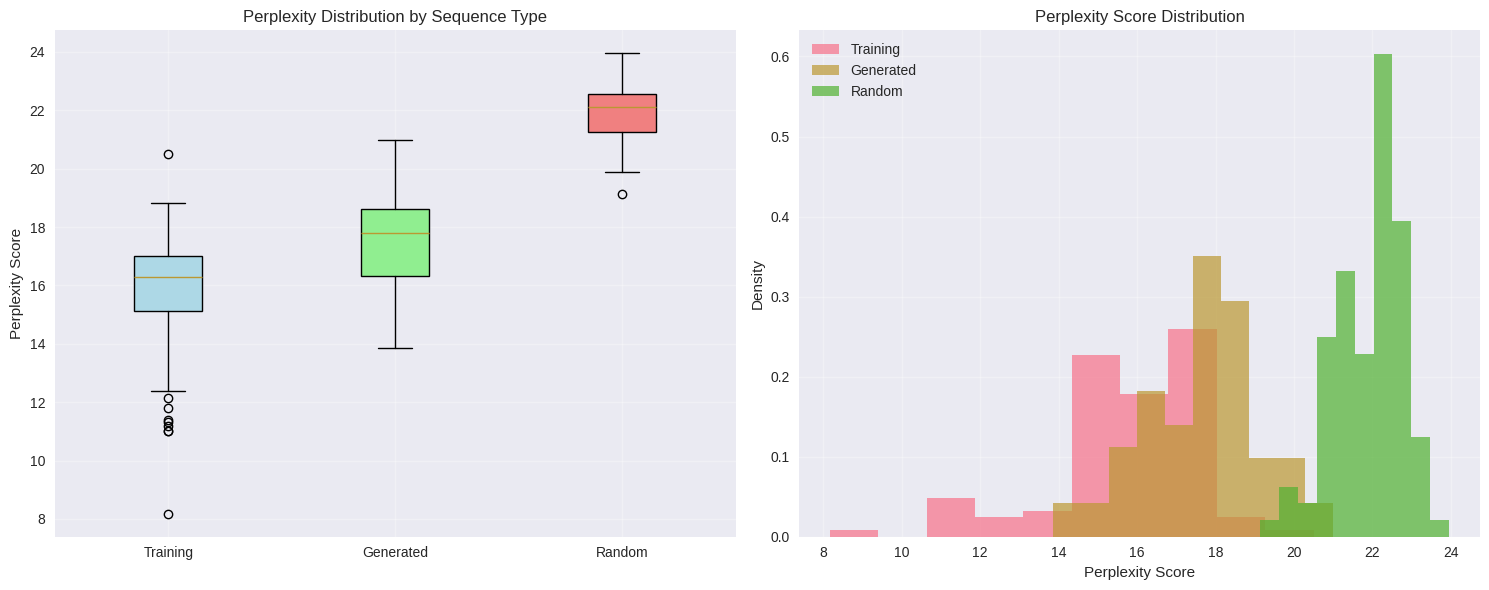


Perplexity Analysis Results:
Training:
  Mean: 15.81
  Std: 1.94
  Min: 8.18
  Max: 20.50
Generated:
  Mean: 17.62
  Std: 1.49
  Min: 13.85
  Max: 20.99
Random:
  Mean: 21.91
  Std: 0.85
  Min: 19.14
  Max: 23.95


In [ ]:

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Box plot
data_to_plot = [perplexity_results['Training'], perplexity_results['Generated'], perplexity_results['Random']]
labels = ['Training', 'Generated', 'Random']

bp = ax1.boxplot(data_to_plot, labels=labels, patch_artist=True)
colors = ['lightblue', 'lightgreen', 'lightcoral']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

ax1.set_ylabel('Perplexity Score')
ax1.set_title('Perplexity Distribution by Sequence Type')
ax1.grid(True, alpha=0.3)

# Histogram comparison
ax2.hist(perplexity_results['Training'], alpha=0.7, label='Training', bins=10, density=True)
ax2.hist(perplexity_results['Generated'], alpha=0.7, label='Generated', bins=10, density=True)
ax2.hist(perplexity_results['Random'], alpha=0.7, label='Random', bins=10, density=True)

ax2.set_xlabel('Perplexity Score')
ax2.set_ylabel('Density')
ax2.set_title('Perplexity Score Distribution')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistics
print("\nPerplexity Analysis Results:")
for seq_type in ['Training', 'Generated', 'Random']:
    scores = perplexity_results[seq_type]
    print(f"{seq_type}:")
    print(f"  Mean: {np.mean(scores):.2f}")
    print(f"  Std: {np.std(scores):.2f}")
    print(f"  Min: {np.min(scores):.2f}")
    print(f"  Max: {np.max(scores):.2f}")

### pLDDT

Calculating pLDDT scores...


Training pLDDT:   0%|          | 0/100 [00:00<?, ?it/s]

Random pLDDT: 100%|██████████| 100/100 [01:39<00:00,  1.01it/s]


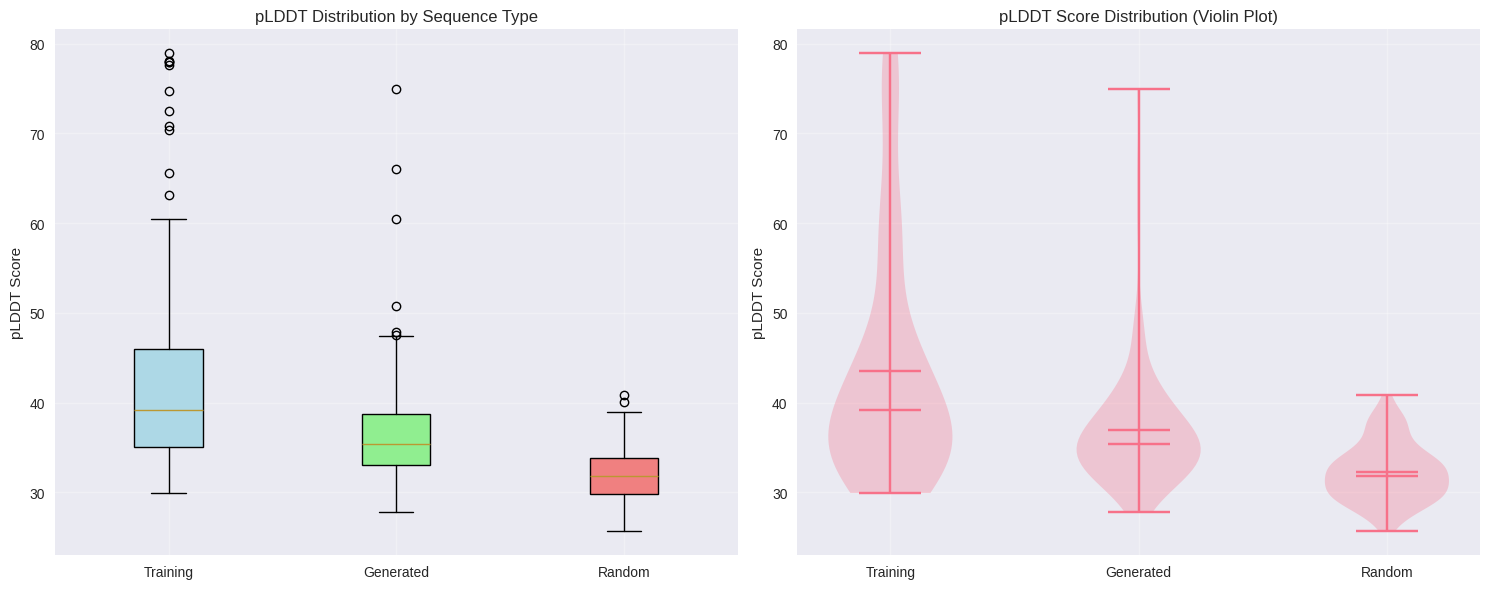


pLDDT Analysis Results:
Training:
  Mean: 43.46
  Std: 13.01
  Min: 29.92
  Max: 78.93
Generated:
  Mean: 36.99
  Std: 6.91
  Min: 27.78
  Max: 75.00
Random:
  Mean: 32.24
  Std: 3.26
  Min: 25.64
  Max: 40.82

Structure Quality Assessment:
Training: 9.0% high confidence (>70 pLDDT)
Generated: 1.0% high confidence (>70 pLDDT)
Random: 0.0% high confidence (>70 pLDDT)


In [ ]:
# Calculate pLDDT scores for structure prediction confidence
print("Calculating pLDDT scores...")

# Sample fewer sequences for pLDDT (structure prediction is expensive)
sample_size = N_SAMPLES

plddt_results = {
    'Training': [],
    'Generated': [],
    'Random': []
}

# Calculate pLDDT scores
for i in tqdm(range(sample_size), desc="Training pLDDT"):
    plddt_mean, _ = calculate_plddt(
        seq=training_sequences[i],
        fold_model=fold_model,
        fold_tokenizer=fold_tokenizer,
        device=device
    )
    plddt_results['Training'].append(plddt_mean)

for i in tqdm(range(sample_size), desc="Generated pLDDT"):
    plddt_mean, _ = calculate_plddt(
        seq=generated_sequences[i],
        fold_model=fold_model,
        fold_tokenizer=fold_tokenizer,
        device=device
    )
    plddt_results['Generated'].append(plddt_mean)

for i in tqdm(range(sample_size), desc="Random pLDDT"):
    plddt_mean, _ = calculate_plddt(
        seq=random_sequences[i],
        fold_model=fold_model,
        fold_tokenizer=fold_tokenizer,
        device=device
    )
    plddt_results['Random'].append(plddt_mean)

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Box plot
data_to_plot = [plddt_results['Training'], plddt_results['Generated'], plddt_results['Random']]
labels = ['Training', 'Generated', 'Random']

bp = ax1.boxplot(data_to_plot, labels=labels, patch_artist=True)
colors = ['lightblue', 'lightgreen', 'lightcoral']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

ax1.set_ylabel('pLDDT Score')
ax1.set_title('pLDDT Distribution by Sequence Type')
ax1.grid(True, alpha=0.3)

# Violin plot
parts = ax2.violinplot(data_to_plot, positions=[1, 2, 3], showmeans=True, showmedians=True)
ax2.set_xticks([1, 2, 3])
ax2.set_xticklabels(labels)
ax2.set_ylabel('pLDDT Score')
ax2.set_title('pLDDT Score Distribution (Violin Plot)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistics
print("\npLDDT Analysis Results:")
for seq_type in ['Training', 'Generated', 'Random']:
    scores = plddt_results[seq_type]
    print(f"{seq_type}:")
    print(f"  Mean: {np.mean(scores):.2f}")
    print(f"  Std: {np.std(scores):.2f}")
    print(f"  Min: {np.min(scores):.2f}")
    print(f"  Max: {np.max(scores):.2f}")

# Quality assessment
print("\nStructure Quality Assessment:")
for seq_type in ['Training', 'Generated', 'Random']:
    scores = plddt_results[seq_type]
    high_confidence = sum(1 for score in scores if score > 70) / len(scores) * 100
    print(f"{seq_type}: {high_confidence:.1f}% high confidence (>70 pLDDT)")

## NOVELTY METRICS

### HAMMING DISTANCE

In [ ]:
# 1) Calcul des distances minimales
avg_gen, dist_gen = calculate_min_hamming_distance(generated_sequences, training_sequences)
avg_rand, dist_rand = calculate_min_hamming_distance(random_sequences,    training_sequences)

Calculating minimum Hamming distances...


Hamming distances: 100%|██████████| 1000/1000 [00:06<00:00, 160.25it/s]


Calculating minimum Hamming distances...


Hamming distances: 100%|██████████| 1000/1000 [00:06<00:00, 152.80it/s]


Hamming Analysis Results:
Generated: Mean = 0.78, Std = 0.17
Random: Mean = 0.87, Std = 0.01


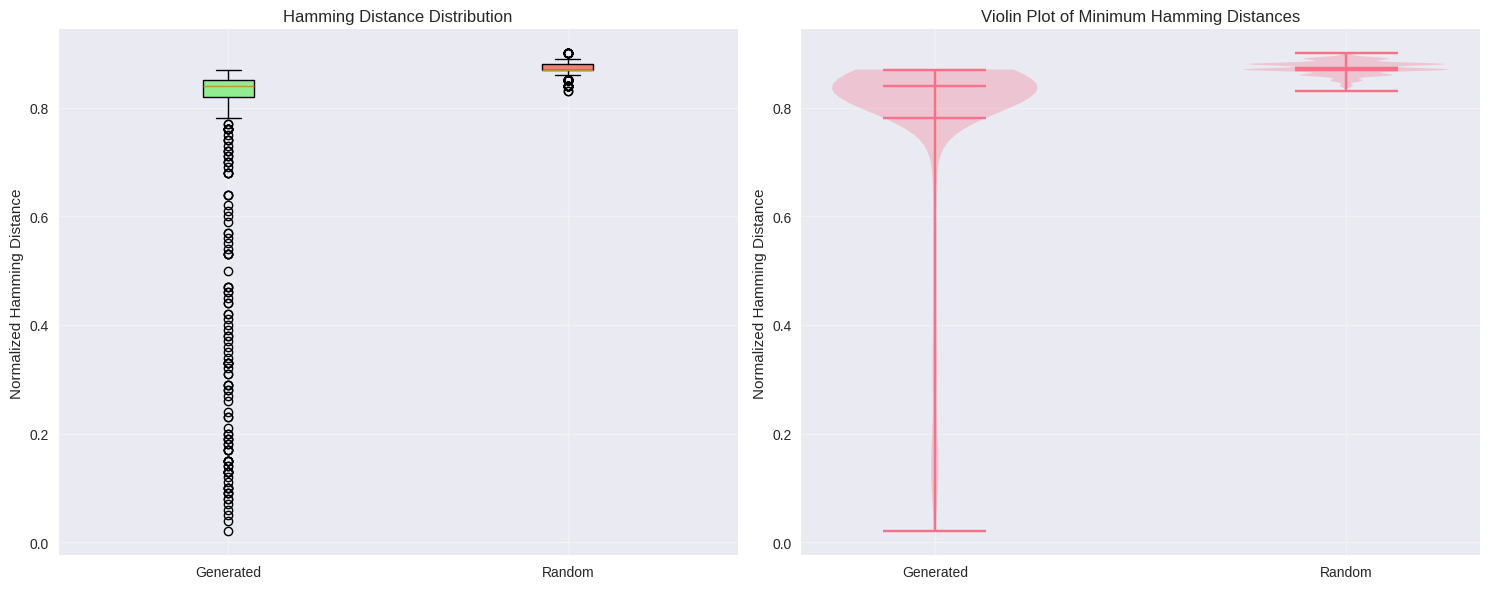

In [ ]:

# 2) Statistiques
print("Hamming Analysis Results:")
for label, avg, dists in [
    ("Generated", avg_gen, dist_gen),
    ("Random",    avg_rand, dist_rand)
]:
    print(f"{label}: Mean = {avg:.2f}, Std = {np.std(dists):.2f}")

# 3) Visualisation : boxplot à gauche, violin à droite
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

data_to_plot = [dist_gen, dist_rand]
labels      = ['Generated', 'Random']

# -- Boxplot sur le subplot de gauche
bp = ax1.boxplot(data_to_plot, labels=labels, patch_artist=True)
colors = ['lightgreen', 'lightcoral']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
ax1.set_ylabel('Normalized Hamming Distance')
ax1.set_title('Hamming Distance Distribution')
ax1.grid(True, alpha=0.3)

# -- Violin plot sur le subplot de droite
parts = ax2.violinplot(
    data_to_plot,
    positions=[1, 2],
    showmeans=True,
    showmedians=True
)
ax2.set_xticks([1, 2])
ax2.set_xticklabels(labels)
ax2.set_ylabel('Normalized Hamming Distance')
ax2.set_title('Violin Plot of Minimum Hamming Distances')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## DIVERSITY AND FIDELITY METRICS

### SOFT ALIGNMENT DISTANCE (FIDELITY)

In [ ]:
# Calculate Soft Alignment Metrics
print("Calculating Soft Alignment Metrics...")

# 1) Appels à la fonction modifiée (retourne mean_distance et liste des max_paths)
mean_dist_gen_fid, gen_max_paths_fid = calculate_min_soft_alignment_distance(
    generated_sequences=generated_sequences,
    training_sequences=training_sequences,
    ppl_model=ppl_model,
    ppl_tokenizer=ppl_tokenizer,
    device=device,
    k=5
)
mean_dist_rand_fid, rand_max_paths_fid = calculate_min_soft_alignment_distance(
    generated_sequences=random_sequences,
    training_sequences=training_sequences,
    ppl_model=ppl_model,
    ppl_tokenizer=ppl_tokenizer,
    device=device,
    k=5
)

print("mean_dist_gen:", mean_dist_gen_fid)
print("mean_dist_rand:", mean_dist_rand_fid)

Calculating Soft Alignment Metrics...
Extracting mean-pooled embeddings for training sequences...


Embed train seqs: 100%|██████████| 100/100 [00:00<00:00, 160.95it/s]


Building FAISS index...


Query gen seqs: 100%|██████████| 100/100 [00:56<00:00,  1.77it/s]


Extracting mean-pooled embeddings for training sequences...


Embed train seqs: 100%|██████████| 100/100 [00:00<00:00, 135.84it/s]


Building FAISS index...


Query gen seqs: 100%|██████████| 100/100 [00:55<00:00,  1.79it/s]

mean_dist_gen: 0.4922000000000001
mean_dist_rand: 0.9830000000000001


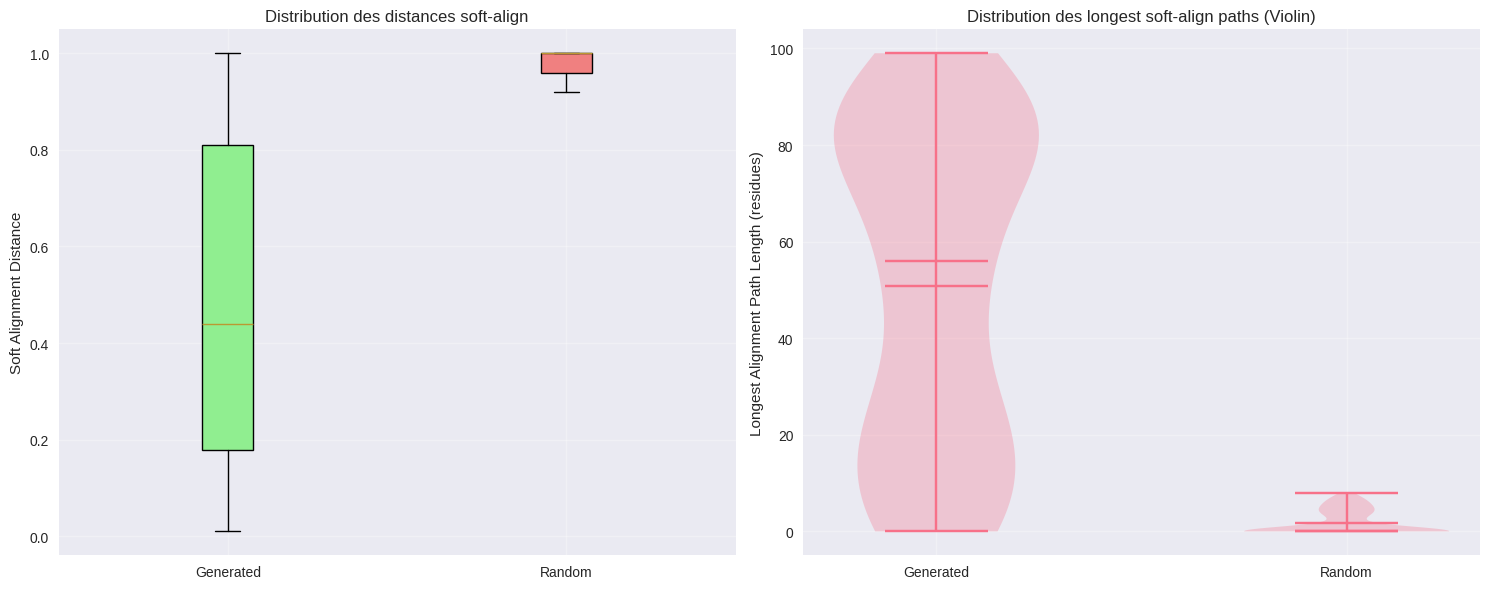


Soft Alignment Analysis:

Generated:
  Mean distance:            0.492
  Std distance:             0.334
  Mean path length:         50.8 residues
  Std path length:          33.4 residues
  Min / Max path length:    0.0 / 99.0 residues

Random:
  Mean distance:            0.983
  Std distance:             0.025
  Mean path length:         1.7 residues
  Std path length:          2.5 residues
  Min / Max path length:    0.0 / 8.0 residues


In [ ]:

# 2) Compute per-sequence distances from max_paths
gen_distances_fid = [1 - (p / len(seq)) for p, seq in zip(gen_max_paths_fid, generated_sequences)]
rand_distances_fid = [1 - (p / len(seq)) for p, seq in zip(rand_max_paths_fid, random_sequences)]


# 3) Visualization: boxplot of distances + violin of raw path lengths
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# --- Boxplot des distances soft-align ---
data_box = [gen_distances_fid, rand_distances_fid]
labels = ['Generated', 'Random']
bp = ax1.boxplot(data_box, labels=labels, patch_artist=True)
colors = ['lightgreen', 'lightcoral']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
ax1.set_ylabel('Soft Alignment Distance')
ax1.set_title('Distribution des distances soft-align')
ax1.grid(True, alpha=0.3)

# --- Violin plot des longest paths ---
data_violin = [gen_max_paths_fid, rand_max_paths_fid]
parts = ax2.violinplot(data_violin, positions=[1, 2], showmeans=True, showmedians=True)
ax2.set_xticks([1, 2])
ax2.set_xticklabels(labels)
ax2.set_ylabel('Longest Alignment Path Length (residues)')
ax2.set_title('Distribution des longest soft-align paths (Violin)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 4) Statistiques descriptives
print("\nSoft Alignment Analysis:")
for name, dists, paths in [
    ('Generated', gen_distances_fid, gen_max_paths_fid),
    ('Random',    rand_distances_fid, rand_max_paths_fid)
]:
    arr_d = np.array(dists)
    arr_p = np.array(paths)
    print(f"\n{name}:")
    print(f"  Mean distance:            {arr_d.mean():.3f}")
    print(f"  Std distance:             {arr_d.std():.3f}")
    print(f"  Mean path length:         {arr_p.mean():.1f} residues")
    print(f"  Std path length:          {arr_p.std():.1f} residues")
    print(f"  Min / Max path length:    {arr_p.min():.1f} / {arr_p.max():.1f} residues")


### SOFT ALIGNMENT DISTANCE (DIVERSITY)

In [13]:
# Calculate Soft Alignment Metrics for Diversity Assessment
print("Calculating Soft Alignment Metrics for Diversity...")

# For diversity: training sequences are the reference, we look at their alignment with generated/random sets
# Generated sequences diversity
mean_dist_gen_div, gen_max_paths_div = calculate_min_soft_alignment_distance(
    generated_sequences=training_sequences,  # Reference: training sequences
    training_sequences=generated_sequences,  # Target: generated sequences
    ppl_model=ppl_model,
    ppl_tokenizer=ppl_tokenizer,
    device=device,
    k=5
)

# Random sequences diversity
mean_dist_rand_div, rand_max_paths_div = calculate_min_soft_alignment_distance(
    generated_sequences=training_sequences,  # Reference: training sequences
    training_sequences=random_sequences,     # Target: random sequences
    ppl_model=ppl_model,
    ppl_tokenizer=ppl_tokenizer,
    device=device,
    k=5
)

print("mean_dist_gen:", mean_dist_gen_div)
print("mean_dist_rand:", mean_dist_rand_div)

Calculating Soft Alignment Metrics for Diversity...
Extracting mean-pooled embeddings for training sequences...


Embed train seqs: 100%|██████████| 1000/1000 [00:07<00:00, 128.18it/s]


Building FAISS index...


Query gen seqs: 100%|██████████| 1000/1000 [09:57<00:00,  1.67it/s]


Extracting mean-pooled embeddings for training sequences...


Embed train seqs: 100%|██████████| 1000/1000 [00:06<00:00, 160.38it/s]


Building FAISS index...


Query gen seqs: 100%|██████████| 1000/1000 [09:41<00:00,  1.72it/s]

mean_dist_gen: 0.5497799999999999
mean_dist_rand: 0.9719300000000001


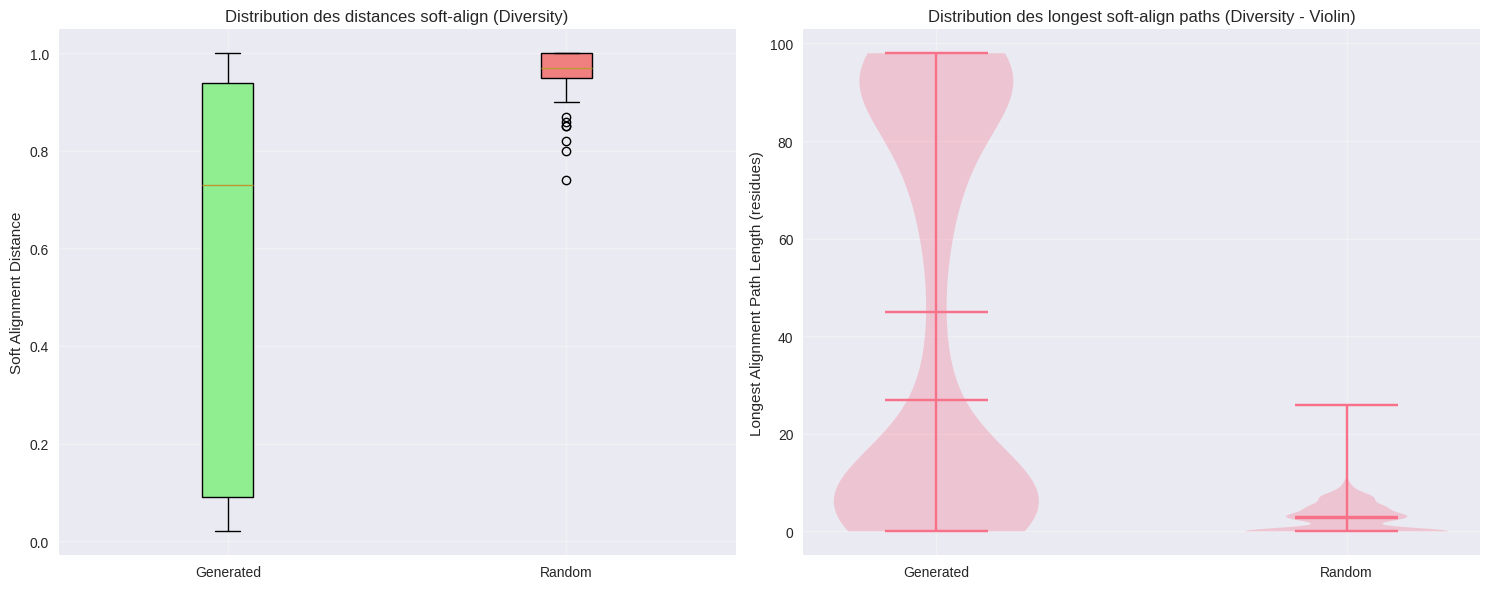


Soft Alignment Analysis (Diversity):

Generated:
 Mean distance: 0.550
 Std distance: 0.404
 Mean path length: 45.0 residues
 Std path length: 40.4 residues
 Min / Max path length: 0.0 / 98.0 residues

Random:
 Mean distance: 0.972
 Std distance: 0.030
 Mean path length: 2.8 residues
 Std path length: 3.0 residues
 Min / Max path length: 0.0 / 26.0 residues


In [15]:
# Compute per-sequence distances from max_paths
gen_distances_div = [1 - (p / len(seq)) for p, seq in zip(gen_max_paths_div, training_sequences)]
rand_distances_div = [1 - (p / len(seq)) for p, seq in zip(rand_max_paths_div, training_sequences)]

# Visualization: boxplot of distances + violin of raw path lengths
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# --- Boxplot des distances soft-align ---
data_box = [gen_distances_div, rand_distances_div]
labels = ['Generated', 'Random']
bp = ax1.boxplot(data_box, labels=labels, patch_artist=True)
colors = ['lightgreen', 'lightcoral']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

ax1.set_ylabel('Soft Alignment Distance')
ax1.set_title('Distribution des distances soft-align (Diversity)')
ax1.grid(True, alpha=0.3)

# --- Violin plot des longest paths ---
data_violin = [gen_max_paths_div, rand_max_paths_div]
parts = ax2.violinplot(data_violin, positions=[1, 2], showmeans=True, showmedians=True)
ax2.set_xticks([1, 2])
ax2.set_xticklabels(labels)
ax2.set_ylabel('Longest Alignment Path Length (residues)')
ax2.set_title('Distribution des longest soft-align paths (Diversity - Violin)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistiques descriptives
print("\nSoft Alignment Analysis (Diversity):")
for name, dists, paths in [
    ('Generated', gen_distances_div, gen_max_paths_div),
    ('Random', rand_distances_div, rand_max_paths_div)
]:
    arr_d = np.array(dists)
    arr_p = np.array(paths)
    
    print(f"\n{name}:")
    print(f" Mean distance: {arr_d.mean():.3f}")
    print(f" Std distance: {arr_d.std():.3f}")
    print(f" Mean path length: {arr_p.mean():.1f} residues")
    print(f" Std path length: {arr_p.std():.1f} residues")
    print(f" Min / Max path length: {arr_p.min():.1f} / {arr_p.max():.1f} residues")


DIVERSITY ANALYSIS: Training sequences covered within alignment threshold


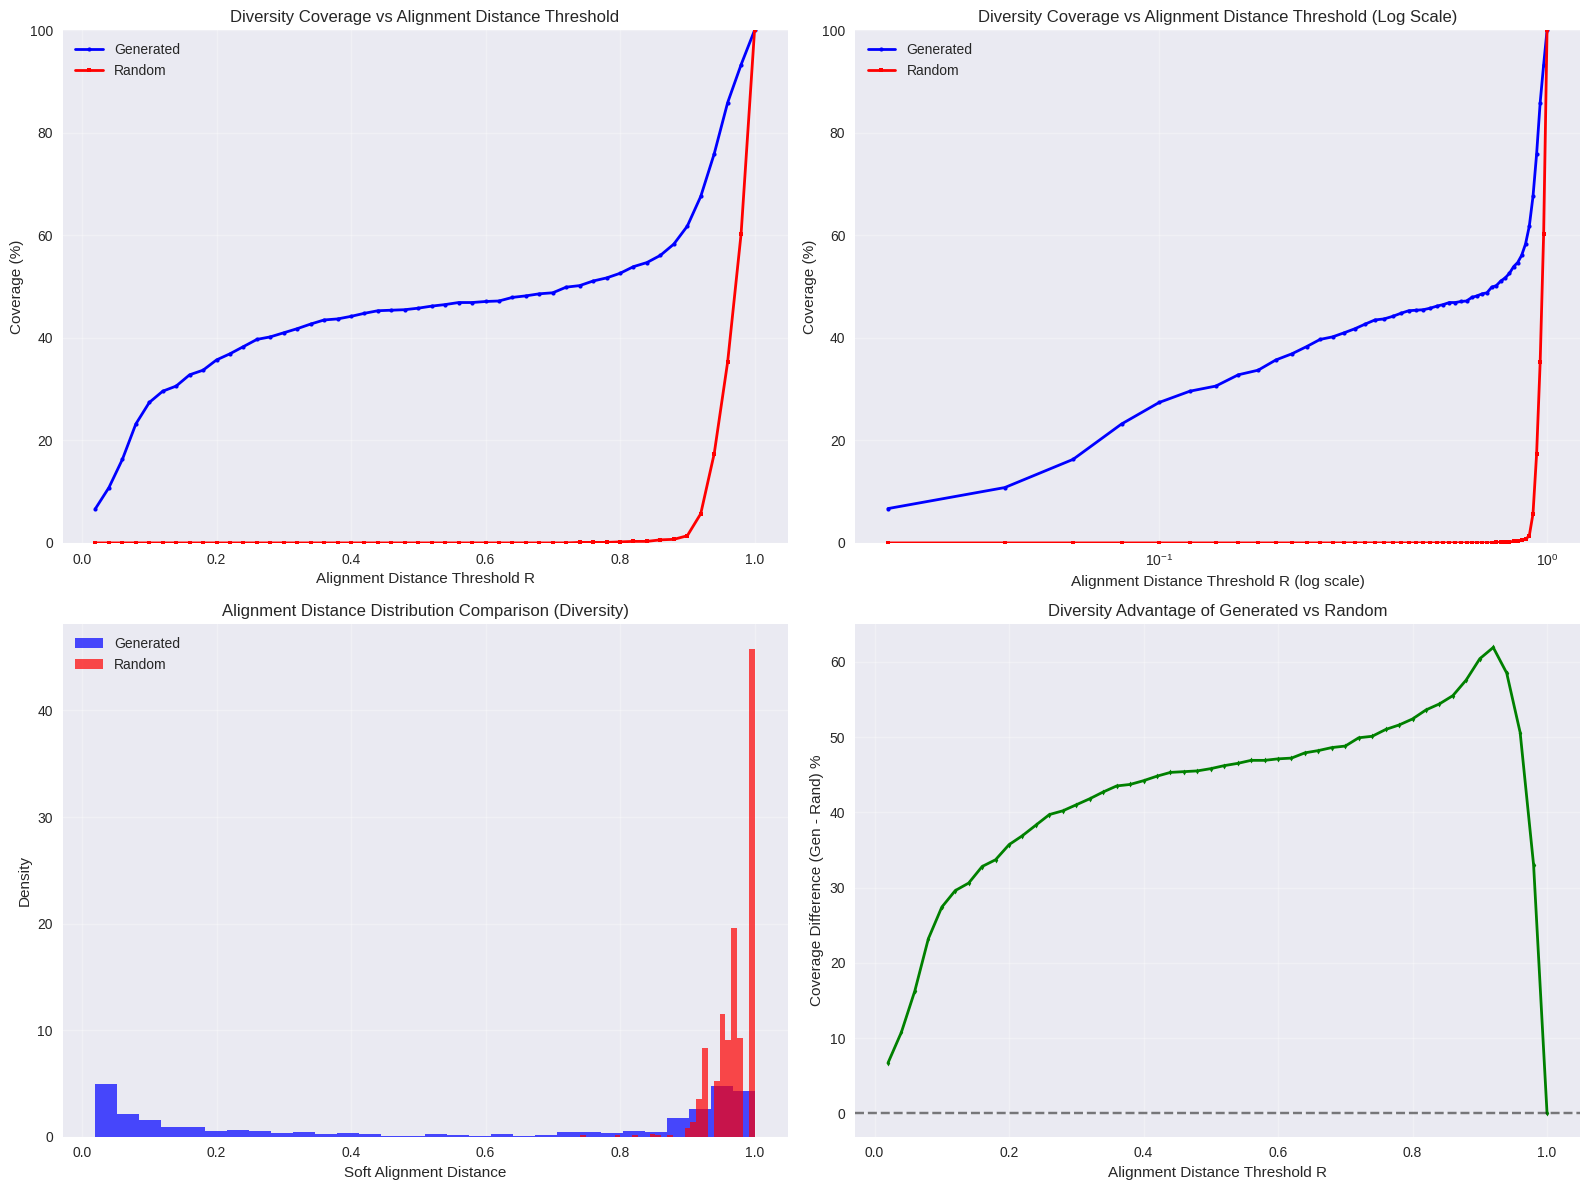


Detailed Diversity Coverage Analysis:
--------------------------------------------------

Threshold R = 0.0300 (Generated 10th percentile):
  Generated: 108/1000 training sequences covered (10.8%)
  Random:    0/1000 training sequences covered (0.0%)
  Advantage: +10.8 percentage points

Threshold R = 0.0900 (Generated 25th percentile):
  Generated: 254/1000 training sequences covered (25.4%)
  Random:    0/1000 training sequences covered (0.0%)
  Advantage: +25.4 percentage points

Threshold R = 0.7300 (Generated 50th percentile):
  Generated: 501/1000 training sequences covered (50.1%)
  Random:    0/1000 training sequences covered (0.0%)
  Advantage: +50.1 percentage points

Threshold R = 0.9400 (Generated 75th percentile):
  Generated: 759/1000 training sequences covered (75.9%)
  Random:    174/1000 training sequences covered (17.4%)
  Advantage: +58.5 percentage points

Threshold R = 0.9700 (Generated 90th percentile):
  Generated: 912/1000 training sequences covered (91.2%)
  R

In [16]:
# Coverage analysis for different distance thresholds
print("\n" + "="*60)
print("DIVERSITY ANALYSIS: Training sequences covered within alignment threshold")
print("="*60)

# Define range of thresholds to analyze
gen_arr = np.array(gen_distances_div)
rand_arr = np.array(rand_distances_div)

# Smart threshold selection based on data distribution
min_thresh = min(gen_arr.min(), rand_arr.min())
max_thresh = max(gen_arr.max(), rand_arr.max())
thresholds = np.linspace(min_thresh, max_thresh, 50)

# Calculate coverage for each threshold
gen_coverage = []
rand_coverage = []

for R in thresholds:
    gen_count = np.sum(gen_arr <= R)
    rand_count = np.sum(rand_arr <= R)
    
    gen_coverage.append(gen_count / len(gen_arr) * 100)
    rand_coverage.append(rand_count / len(rand_arr) * 100)

# Create comprehensive visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# --- Coverage curves ---
ax1.plot(thresholds, gen_coverage, 'b-', linewidth=2, label='Generated', marker='o', markersize=3)
ax1.plot(thresholds, rand_coverage, 'r-', linewidth=2, label='Random', marker='s', markersize=3)
ax1.set_xlabel('Alignment Distance Threshold R')
ax1.set_ylabel('Coverage (%)')
ax1.set_title('Diversity Coverage vs Alignment Distance Threshold')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 100)

# --- Log-scale coverage (for better resolution at low thresholds) ---
ax2.semilogx(thresholds, gen_coverage, 'b-', linewidth=2, label='Generated', marker='o', markersize=3)
ax2.semilogx(thresholds, rand_coverage, 'r-', linewidth=2, label='Random', marker='s', markersize=3)
ax2.set_xlabel('Alignment Distance Threshold R (log scale)')
ax2.set_ylabel('Coverage (%)')
ax2.set_title('Diversity Coverage vs Alignment Distance Threshold (Log Scale)')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, 100)

# --- Histogram comparison ---
ax3.hist(gen_distances_div, bins=30, alpha=0.7, color='blue', label='Generated', density=True)
ax3.hist(rand_distances_div, bins=30, alpha=0.7, color='red', label='Random', density=True)
ax3.set_xlabel('Soft Alignment Distance')
ax3.set_ylabel('Density')
ax3.set_title('Alignment Distance Distribution Comparison (Diversity)')
ax3.legend()
ax3.grid(True, alpha=0.3)

# --- Coverage difference ---
coverage_diff = np.array(gen_coverage) - np.array(rand_coverage)
ax4.plot(thresholds, coverage_diff, 'g-', linewidth=2, marker='d', markersize=3)
ax4.axhline(y=0, color='k', linestyle='--', alpha=0.5)
ax4.set_xlabel('Alignment Distance Threshold R')
ax4.set_ylabel('Coverage Difference (Gen - Rand) %')
ax4.set_title('Diversity Advantage of Generated vs Random')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print detailed analysis for key thresholds
print("\nDetailed Diversity Coverage Analysis:")
print("-" * 50)
key_percentiles = [10, 25, 50, 75, 90]
key_thresholds = [np.percentile(gen_arr, p) for p in key_percentiles]

for i, (percentile, thresh) in enumerate(zip(key_percentiles, key_thresholds)):
    gen_count = np.sum(gen_arr <= thresh)
    rand_count = np.sum(rand_arr <= thresh)
    
    gen_pct = gen_count / len(gen_arr) * 100
    rand_pct = rand_count / len(rand_arr) * 100
    
    print(f"\nThreshold R = {thresh:.4f} (Generated {percentile}th percentile):")
    print(f"  Generated: {gen_count}/{len(gen_arr)} training sequences covered ({gen_pct:.1f}%)")
    print(f"  Random:    {rand_count}/{len(rand_arr)} training sequences covered ({rand_pct:.1f}%)")
    print(f"  Advantage: {gen_pct - rand_pct:+.1f} percentage points")

# Summary statistics
print(f"\nSummary Statistics (Diversity):")
print(f"  Mean distance ratio (Gen/Rand): {mean_dist_gen_div/mean_dist_rand_div:.3f}")
print(f"  Median distance ratio: {np.median(gen_arr)/np.median(rand_arr):.3f}")
print(f"  Training sequences covered by Generated < median(Random): {np.sum(gen_arr < np.median(rand_arr))}/{len(gen_arr)} ({np.sum(gen_arr < np.median(rand_arr))/len(gen_arr)*100:.1f}%)")
print(f"  Training sequences covered by Random < median(Generated): {np.sum(rand_arr < np.median(gen_arr))}/{len(rand_arr)} ({np.sum(rand_arr < np.median(gen_arr))/len(rand_arr)*100:.1f}%)")

# Path length analysis
print(f"\nPath Length Analysis:")
gen_paths_arr = np.array(gen_max_paths_div)
rand_paths_arr = np.array(rand_max_paths_div)
print(f"  Mean path length ratio (Gen/Rand): {gen_paths_arr.mean()/rand_paths_arr.mean():.3f}")
print(f"  Median path length ratio: {np.median(gen_paths_arr)/np.median(rand_paths_arr):.3f}")
print(f"  Generated with path length > median(Random): {np.sum(gen_paths_arr > np.median(rand_paths_arr))}/{len(gen_paths_arr)} ({np.sum(gen_paths_arr > np.median(rand_paths_arr))/len(gen_paths_arr)*100:.1f}%)")
print(f"  Random with path length > median(Generated): {np.sum(rand_paths_arr > np.median(gen_paths_arr))}/{len(rand_paths_arr)} ({np.sum(rand_paths_arr > np.median(gen_paths_arr))/len(rand_paths_arr)*100:.1f}%)")

### KNN (FIDELITY)

In [4]:
# Calculate KNN Embedding Distance Metrics
print("Calculating KNN Embedding Distance Metrics...")

# Generated sequences
mean_dist_gen, gen_distances = calculate_knn_embedding_distance(
    generated_sequences=generated_sequences,
    training_sequences=training_sequences,
    ppl_model=ppl_model,
    ppl_tokenizer=ppl_tokenizer,
    device=device,
    k=3
)

# Random sequences
mean_dist_rand, rand_distances = calculate_knn_embedding_distance(
    generated_sequences=random_sequences,
    training_sequences=training_sequences,
    ppl_model=ppl_model,
    ppl_tokenizer=ppl_tokenizer,
    device=device,
    k=3
)

print("mean_dist_gen:", mean_dist_gen)
print("mean_dist_rand:", mean_dist_rand)

Calculating KNN Embedding Distance Metrics...
Extracting training embeddings...


Computing KNN distances: 100%|██████████| 1000/1000 [00:06<00:00, 153.59it/s]


Extracting training embeddings...


Computing KNN distances:  65%|██████▍   | 649/1000 [00:04<00:02, 161.71it/s]


KeyboardInterrupt: 

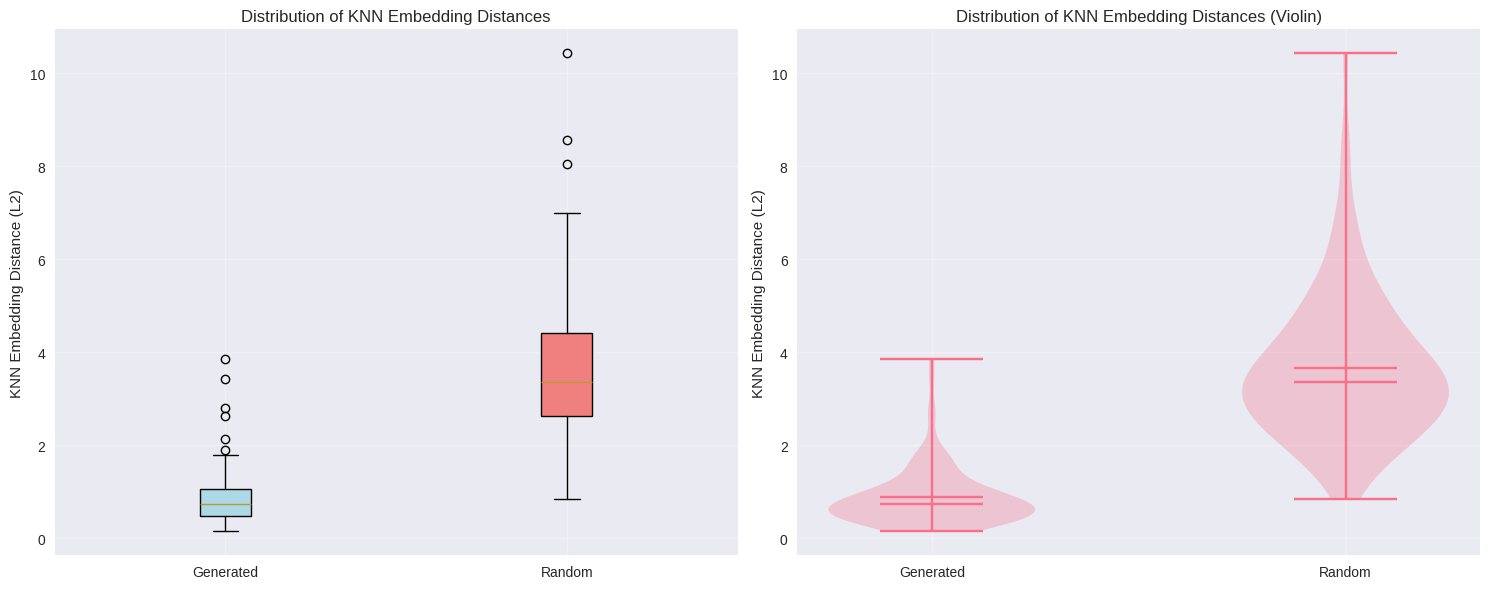


KNN Embedding Distance Analysis:

Generated:
 Mean distance: 0.8860
 Std distance: 0.6398
 Min / Max distance: 0.1508 / 3.8579
 Median distance: 0.7298
 25th / 75th percentile: 0.4856 / 1.0528

Random:
 Mean distance: 3.6728
 Std distance: 1.5915
 Min / Max distance: 0.8376 / 10.4325
 Median distance: 3.3524
 25th / 75th percentile: 2.6339 / 4.4161


In [ ]:
# Visualization: boxplot + violin plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# --- Boxplot des distances KNN ---
data_box = [gen_distances, rand_distances]
labels = ['Generated', 'Random']
bp = ax1.boxplot(data_box, labels=labels, patch_artist=True)
colors = ['lightblue', 'lightcoral']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

ax1.set_ylabel('KNN Embedding Distance (L2)')
ax1.set_title('Distribution of KNN Embedding Distances')
ax1.grid(True, alpha=0.3)

# --- Violin plot des distances KNN ---
parts = ax2.violinplot(data_box, positions=[1, 2], showmeans=True, showmedians=True)
ax2.set_xticks([1, 2])
ax2.set_xticklabels(labels)
ax2.set_ylabel('KNN Embedding Distance (L2)')
ax2.set_title('Distribution of KNN Embedding Distances (Violin)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Descriptive statistics
print("\nKNN Embedding Distance Analysis:")
for name, dists in [('Generated', gen_distances), ('Random', rand_distances)]:
    arr_d = np.array(dists)
    print(f"\n{name}:")
    print(f" Mean distance: {arr_d.mean():.4f}")
    print(f" Std distance: {arr_d.std():.4f}")
    print(f" Min / Max distance: {arr_d.min():.4f} / {arr_d.max():.4f}")
    print(f" Median distance: {np.median(arr_d):.4f}")
    print(f" 25th / 75th percentile: {np.percentile(arr_d, 25):.4f} / {np.percentile(arr_d, 75):.4f}")

### KNN (DIVERSITY)

In [11]:
# Calculate KNN Embedding Distance Metrics for Diversity Assessment
print("Calculating KNN Embedding Distance Metrics for Diversity...")

# For diversity: training sequences are the reference, we look at their neighbors in generated/random sets
# Generated sequences diversity
mean_dist_gen, gen_distances = calculate_knn_embedding_distance(
    generated_sequences=training_sequences,  # Reference: training sequences
    training_sequences=generated_sequences,  # Target: generated sequences
    ppl_model=ppl_model,
    ppl_tokenizer=ppl_tokenizer,
    device=device,
    k=3
)

# Random sequences diversity
mean_dist_rand, rand_distances = calculate_knn_embedding_distance(
    generated_sequences=training_sequences,  # Reference: training sequences
    training_sequences=random_sequences,     # Target: random sequences
    ppl_model=ppl_model,
    ppl_tokenizer=ppl_tokenizer,
    device=device,
    k=3
)

print("mean_dist_gen:", mean_dist_gen)
print("mean_dist_rand:", mean_dist_rand)

Calculating KNN Embedding Distance Metrics for Diversity...
Extracting training embeddings...


Computing KNN distances: 100%|██████████| 1000/1000 [00:06<00:00, 147.34it/s]


Extracting training embeddings...


Computing KNN distances: 100%|██████████| 1000/1000 [00:06<00:00, 156.23it/s]


mean_dist_gen: 5.429407076120377
mean_dist_rand: 5.247071674108505


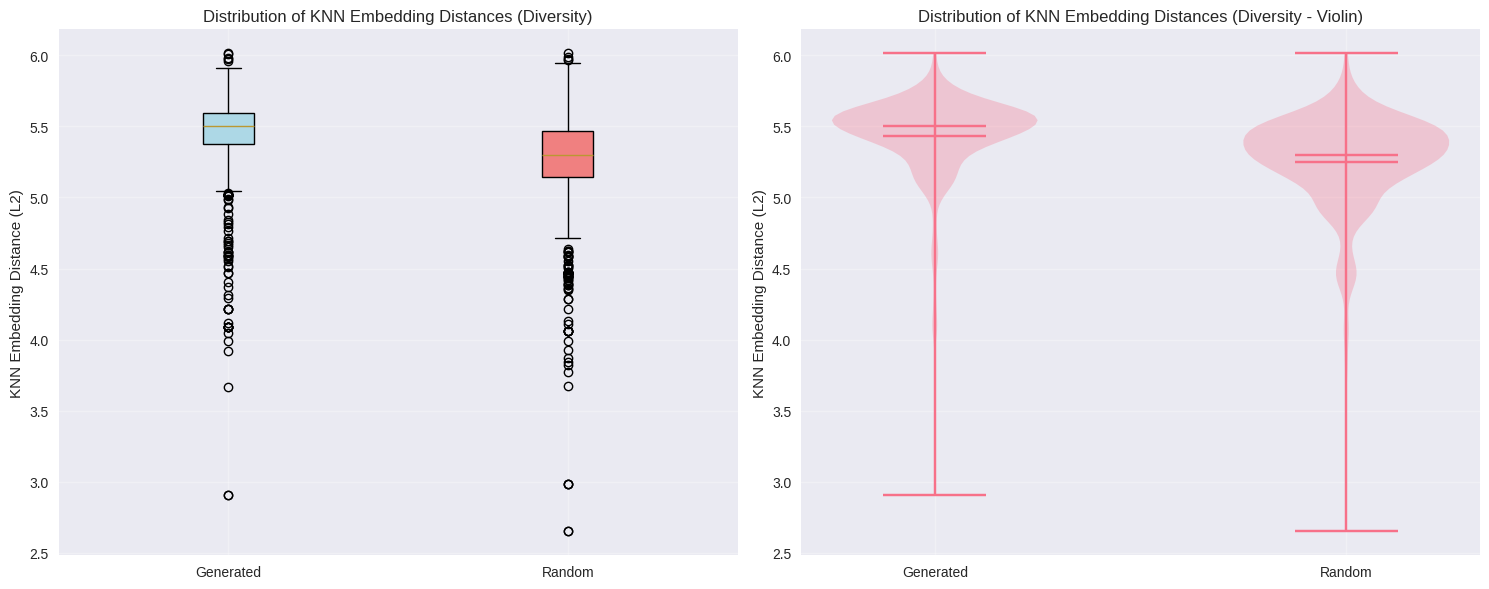


KNN Embedding Distance Analysis (Diversity):

Generated:
 Mean distance: 5.4294
 Std distance: 0.3096
 Min / Max distance: 2.9083 / 6.0132
 Median distance: 5.5025
 25th / 75th percentile: 5.3728 / 5.5956

Random:
 Mean distance: 5.2471
 Std distance: 0.3681
 Min / Max distance: 2.6514 / 6.0141
 Median distance: 5.3009
 25th / 75th percentile: 5.1466 / 5.4693


In [6]:

# Visualization: boxplot + violin plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# --- Boxplot des distances KNN ---
data_box = [gen_distances, rand_distances]
labels = ['Generated', 'Random']
bp = ax1.boxplot(data_box, labels=labels, patch_artist=True)
colors = ['lightblue', 'lightcoral']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

ax1.set_ylabel('KNN Embedding Distance (L2)')
ax1.set_title('Distribution of KNN Embedding Distances (Diversity)')
ax1.grid(True, alpha=0.3)

# --- Violin plot des distances KNN ---
parts = ax2.violinplot(data_box, positions=[1, 2], showmeans=True, showmedians=True)
ax2.set_xticks([1, 2])
ax2.set_xticklabels(labels)
ax2.set_ylabel('KNN Embedding Distance (L2)')
ax2.set_title('Distribution of KNN Embedding Distances (Diversity - Violin)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Descriptive statistics
print("\nKNN Embedding Distance Analysis (Diversity):")
for name, dists in [('Generated', gen_distances), ('Random', rand_distances)]:
    arr_d = np.array(dists)
    print(f"\n{name}:")
    print(f" Mean distance: {arr_d.mean():.4f}")
    print(f" Std distance: {arr_d.std():.4f}")
    print(f" Min / Max distance: {arr_d.min():.4f} / {arr_d.max():.4f}")
    print(f" Median distance: {np.median(arr_d):.4f}")
    print(f" 25th / 75th percentile: {np.percentile(arr_d, 25):.4f} / {np.percentile(arr_d, 75):.4f}")


DIVERSITY ANALYSIS: Training sequences covered within distance threshold


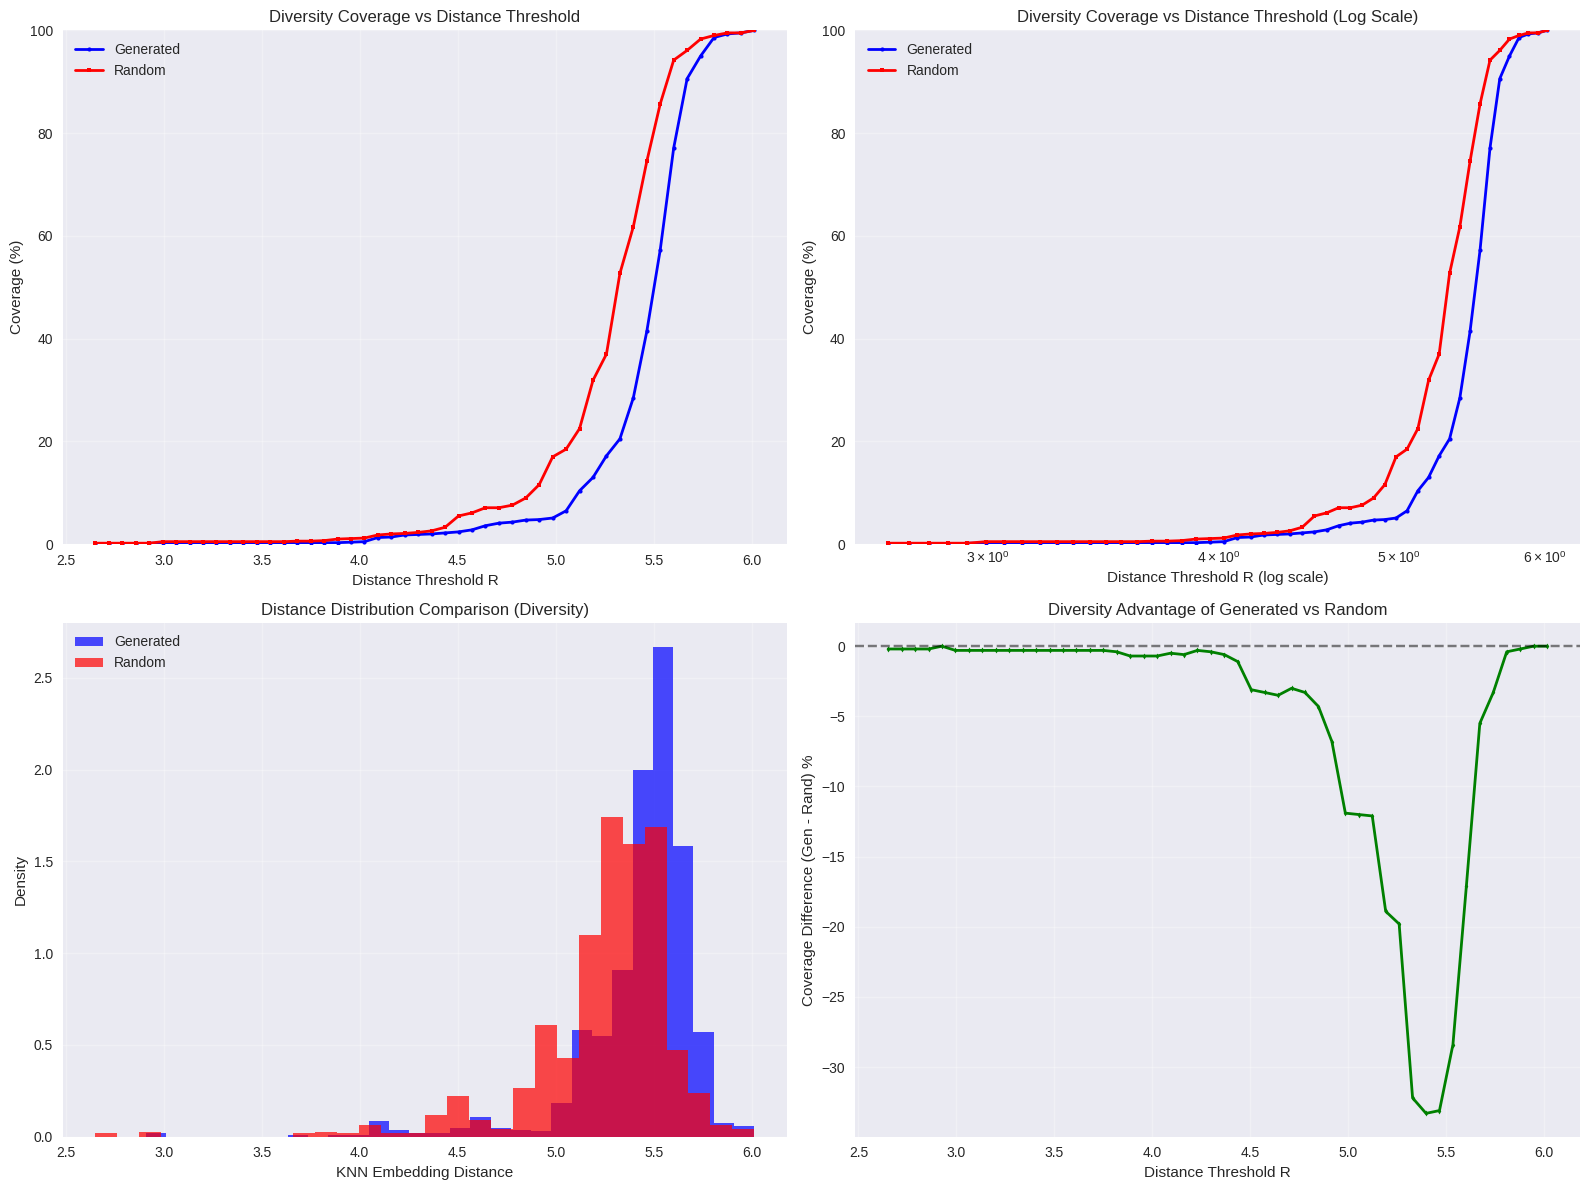


Detailed Diversity Coverage Analysis:
--------------------------------------------------

Threshold R = 5.1108 (Generated 10th percentile):
  Generated: 100/1000 training sequences covered (10.0%)
  Random:    218/1000 training sequences covered (21.8%)
  Advantage: -11.8 percentage points

Threshold R = 5.3728 (Generated 25th percentile):
  Generated: 250/1000 training sequences covered (25.0%)
  Random:    581/1000 training sequences covered (58.1%)
  Advantage: -33.1 percentage points

Threshold R = 5.5025 (Generated 50th percentile):
  Generated: 502/1000 training sequences covered (50.2%)
  Random:    803/1000 training sequences covered (80.3%)
  Advantage: -30.1 percentage points

Threshold R = 5.5956 (Generated 75th percentile):
  Generated: 750/1000 training sequences covered (75.0%)
  Random:    939/1000 training sequences covered (93.9%)
  Advantage: -18.9 percentage points

Threshold R = 5.6664 (Generated 90th percentile):
  Generated: 900/1000 training sequences covered (9

In [12]:

# Coverage analysis for different distance thresholds
print("\n" + "="*60)
print("DIVERSITY ANALYSIS: Training sequences covered within distance threshold")
print("="*60)

# Define range of thresholds to analyze
gen_arr = np.array(gen_distances)
rand_arr = np.array(rand_distances)

# Smart threshold selection based on data distribution
min_thresh = min(gen_arr.min(), rand_arr.min())
max_thresh = max(gen_arr.max(), rand_arr.max())
thresholds = np.linspace(min_thresh, max_thresh, 50)

# Calculate coverage for each threshold
gen_coverage = []
rand_coverage = []

for R in thresholds:
    gen_count = np.sum(gen_arr <= R)
    rand_count = np.sum(rand_arr <= R)
    
    gen_coverage.append(gen_count / len(gen_arr) * 100)
    rand_coverage.append(rand_count / len(rand_arr) * 100)

# Create comprehensive visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# --- Coverage curves ---
ax1.plot(thresholds, gen_coverage, 'b-', linewidth=2, label='Generated', marker='o', markersize=3)
ax1.plot(thresholds, rand_coverage, 'r-', linewidth=2, label='Random', marker='s', markersize=3)
ax1.set_xlabel('Distance Threshold R')
ax1.set_ylabel('Coverage (%)')
ax1.set_title('Diversity Coverage vs Distance Threshold')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 100)

# --- Log-scale coverage (for better resolution at low thresholds) ---
ax2.semilogx(thresholds, gen_coverage, 'b-', linewidth=2, label='Generated', marker='o', markersize=3)
ax2.semilogx(thresholds, rand_coverage, 'r-', linewidth=2, label='Random', marker='s', markersize=3)
ax2.set_xlabel('Distance Threshold R (log scale)')
ax2.set_ylabel('Coverage (%)')
ax2.set_title('Diversity Coverage vs Distance Threshold (Log Scale)')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, 100)

# --- Histogram comparison ---
ax3.hist(gen_distances, bins=30, alpha=0.7, color='blue', label='Generated', density=True)
ax3.hist(rand_distances, bins=30, alpha=0.7, color='red', label='Random', density=True)
ax3.set_xlabel('KNN Embedding Distance')
ax3.set_ylabel('Density')
ax3.set_title('Distance Distribution Comparison (Diversity)')
ax3.legend()
ax3.grid(True, alpha=0.3)

# --- Coverage difference ---
coverage_diff = np.array(gen_coverage) - np.array(rand_coverage)
ax4.plot(thresholds, coverage_diff, 'g-', linewidth=2, marker='d', markersize=3)
ax4.axhline(y=0, color='k', linestyle='--', alpha=0.5)
ax4.set_xlabel('Distance Threshold R')
ax4.set_ylabel('Coverage Difference (Gen - Rand) %')
ax4.set_title('Diversity Advantage of Generated vs Random')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print detailed analysis for key thresholds
print("\nDetailed Diversity Coverage Analysis:")
print("-" * 50)
key_percentiles = [10, 25, 50, 75, 90]
key_thresholds = [np.percentile(gen_arr, p) for p in key_percentiles]

for i, (percentile, thresh) in enumerate(zip(key_percentiles, key_thresholds)):
    gen_count = np.sum(gen_arr <= thresh)
    rand_count = np.sum(rand_arr <= thresh)
    
    gen_pct = gen_count / len(gen_arr) * 100
    rand_pct = rand_count / len(rand_arr) * 100
    
    print(f"\nThreshold R = {thresh:.4f} (Generated {percentile}th percentile):")
    print(f"  Generated: {gen_count}/{len(gen_arr)} training sequences covered ({gen_pct:.1f}%)")
    print(f"  Random:    {rand_count}/{len(rand_arr)} training sequences covered ({rand_pct:.1f}%)")
    print(f"  Advantage: {gen_pct - rand_pct:+.1f} percentage points")

# Summary statistics
print(f"\nSummary Statistics (Diversity):")
print(f"  Mean distance ratio (Gen/Rand): {mean_dist_gen/mean_dist_rand:.3f}")
print(f"  Median distance ratio: {np.median(gen_arr)/np.median(rand_arr):.3f}")
print(f"  Training sequences covered by Generated < median(Random): {np.sum(gen_arr < np.median(rand_arr))}/{len(gen_arr)} ({np.sum(gen_arr < np.median(rand_arr))/len(gen_arr)*100:.1f}%)")
print(f"  Training sequences covered by Random < median(Generated): {np.sum(rand_arr < np.median(gen_arr))}/{len(rand_arr)} ({np.sum(rand_arr < np.median(gen_arr))/len(rand_arr)*100:.1f}%)")

### FRECHET DISTANCE (DIVERSITY AND FIDELITY)

In [ ]:
# Calculate Fréchet ESM Distance to measure distribution similarity
print("Calculating Fréchet ESM Distance...")

# Calculate Fréchet distance between generated and training sequences
frechet_distance = calculate_frechet_esm_distance(
    generated_sequences=generated_sequences,
    test_sequences=training_sequences,
    ppl_model=ppl_model,
    ppl_tokenizer=ppl_tokenizer,
    device=device
)

# Also calculate for random sequences as baseline
random_frechet_distance = calculate_frechet_esm_distance(
    generated_sequences=random_sequences,
    test_sequences=training_sequences,
    ppl_model=ppl_model,
    ppl_tokenizer=ppl_tokenizer,
    device=device
)

print(f"Generated vs Training: {frechet_distance:.2f}")
print(f"Random vs Training: {random_frechet_distance:.2f}")

Calculating Fréchet ESM Distance...
Calculating Fréchet ESM distance...


Extracting embeddings: 100%|██████████| 100/100 [00:00<00:00, 139.78it/s]


Calculating Fréchet ESM distance...


Extracting embeddings: 100%|██████████| 100/100 [00:00<00:00, 156.36it/s]


Generated vs Training: 0.80
Random vs Training: 4.90


Extracting embeddings for visualization...


Extracting embeddings:   0%|          | 0/100 [00:00<?, ?it/s]

Extracting embeddings: 100%|██████████| 100/100 [00:00<00:00, 162.17it/s]


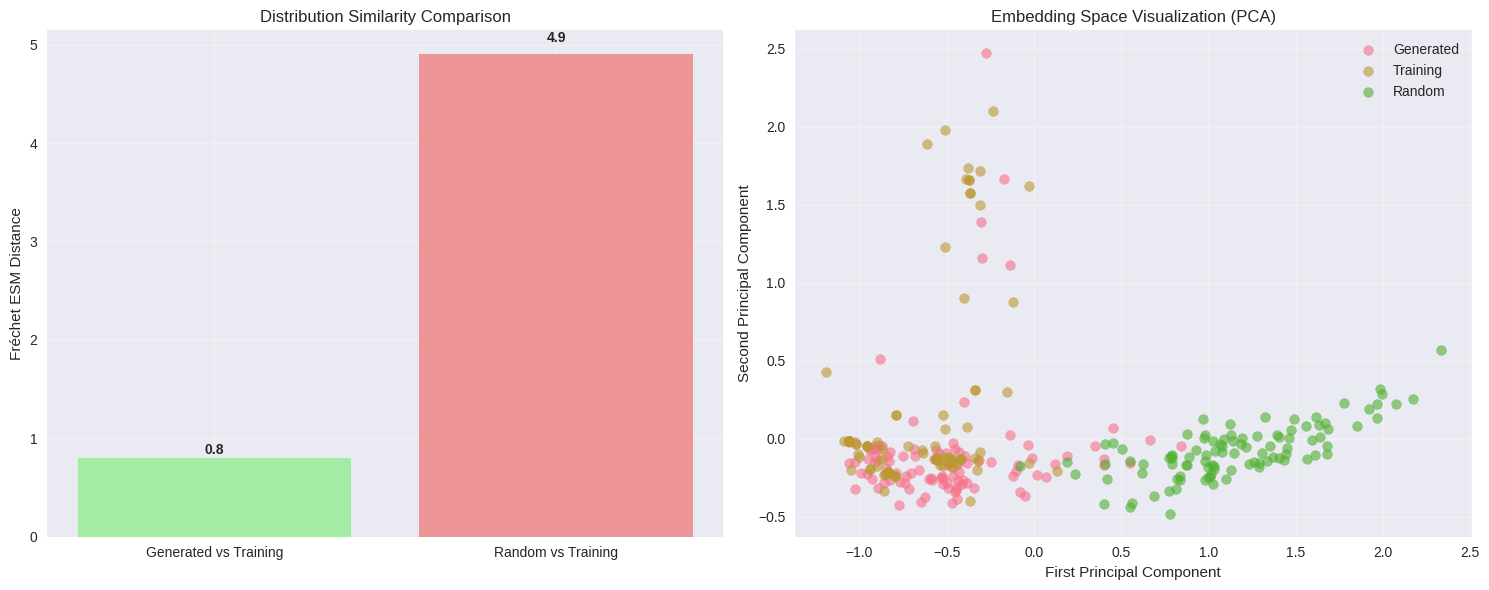


Fréchet ESM Distance Analysis Results:
Generated vs Training: 0.80
Random vs Training: 4.90
Improvement over random: +83.7%


In [ ]:
# Get embeddings for visualization
print("Extracting embeddings for visualization...")
generated_embeddings = get_sequence_embeddings(
    sequences=generated_sequences,
    ppl_model=ppl_model,
    ppl_tokenizer=ppl_tokenizer,
    device=device
)
training_embeddings = get_sequence_embeddings(
    sequences=training_sequences,
    ppl_model=ppl_model,
    ppl_tokenizer=ppl_tokenizer,
    device=device
)
random_embeddings = get_sequence_embeddings(
    sequences=random_sequences,
    ppl_model=ppl_model,
    ppl_tokenizer=ppl_tokenizer,
    device=device
)

# PCA on all three sets
pca = PCA(n_components=2)
all_embeddings = np.vstack([generated_embeddings, training_embeddings, random_embeddings])
all_embeddings_2d = pca.fit_transform(all_embeddings)

g_end = len(generated_embeddings)
t_end = g_end + len(training_embeddings)

generated_2d = all_embeddings_2d[:g_end]
training_2d  = all_embeddings_2d[g_end:t_end]
random_2d    = all_embeddings_2d[t_end:]

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# --- Bar plot: Fréchet distances ---
categories = ['Generated vs Training', 'Random vs Training']
distances  = [frechet_distance, random_frechet_distance]
colors     = ['lightgreen', 'lightcoral']

bars = ax1.bar(categories, distances, color=colors, alpha=0.8)
ax1.set_ylabel('Fréchet ESM Distance')
ax1.set_title('Distribution Similarity Comparison')
ax1.grid(True, alpha=0.3)
for bar, d in zip(bars, distances):
    ax1.text(bar.get_x() + bar.get_width() / 2, d * 1.02, f'{d:.1f}',
             ha='center', va='bottom', fontweight='bold')

# --- PCA scatter plot ---
ax2.scatter(generated_2d[:, 0], generated_2d[:, 1], alpha=0.6, label='Generated', s=50)
ax2.scatter(training_2d[:, 0],  training_2d[:, 1],  alpha=0.6, label='Training',  s=50)
ax2.scatter(random_2d[:, 0],    random_2d[:, 1],    alpha=0.6, label='Random',    s=50)
ax2.set_xlabel('First Principal Component')
ax2.set_ylabel('Second Principal Component')
ax2.set_title('Embedding Space Visualization (PCA)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print results
print("\nFréchet ESM Distance Analysis Results:")
print(f"Generated vs Training: {frechet_distance:.2f}")
print(f"Random vs Training: {random_frechet_distance:.2f}")
print(f"Improvement over random: {((random_frechet_distance - frechet_distance) / random_frechet_distance * 100):+.1f}%")


### SLICED-WASSERSTEIN (DIVERSITY AND FIDELITY)

In [ ]:
# Calculate Sliced Wasserstein Metrics
print("Calculating Sliced Wasserstein Metrics...")

# 1) Appels à la fonction modifiée (retourne mean_distance et liste des distances par projection)
mean_swd_gen, swd_projs_gen = calculate_sliced_wasserstein(
    generated_sequences=generated_sequences,
    training_sequences=training_sequences,
    ppl_model=ppl_model,
    ppl_tokenizer=ppl_tokenizer,
    device=device,
    n_projections=100,
    random_seed=42
)
mean_swd_rand, swd_projs_rand = calculate_sliced_wasserstein(
    generated_sequences=random_sequences,
    training_sequences=training_sequences,
    ppl_model=ppl_model,
    ppl_tokenizer=ppl_tokenizer,
    device=device,
    n_projections=100,
    random_seed=42
)

print(f"mean_swd_gen:  {mean_swd_gen:.4f}")
print(f"mean_swd_rand: {mean_swd_rand:.4f}")

Calculating Sliced Wasserstein Metrics...


Extracting embeddings: 100%|██████████| 100/100 [00:00<00:00, 130.70it/s]

mean_swd_gen:  0.3889
mean_swd_rand: 1.4222


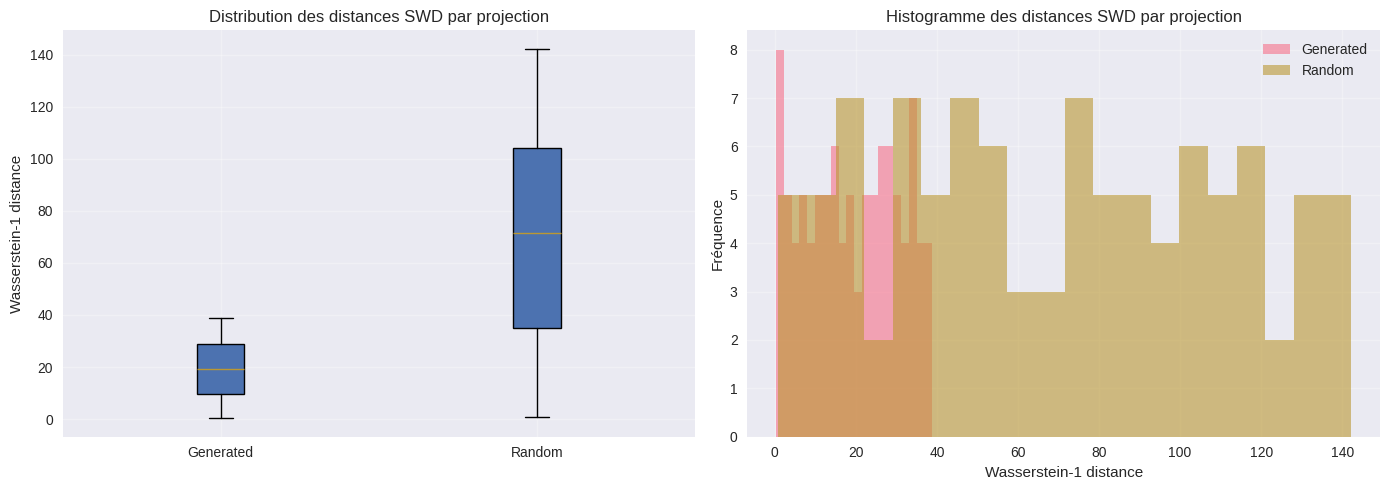


Sliced Wasserstein Analysis:

Generated:
  Mean per projection: 19.2690
  Std per projection:  11.3519
  Min / Max:           0.3159 / 38.8911

Random:
  Mean per projection: 69.7010
  Std per projection:  40.4933
  Min / Max:           0.8619 / 142.2197


In [ ]:
# 2) Visualisation : boxplot des distances par projection + histogramme des distances
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# --- Boxplot des distances SWD-1 par projection ---
data_box = [swd_projs_gen, swd_projs_rand]
labels   = ['Generated', 'Random']
bp = ax1.boxplot(data_box, labels=labels, patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor(None)  # laisser la couleur par défaut
ax1.set_title('Distribution des distances SWD par projection')
ax1.set_ylabel('Wasserstein-1 distance')
ax1.grid(True, alpha=0.3)

# --- Histogramme des distances SWD-1 ---
ax2.hist(swd_projs_gen,    bins=20, alpha=0.6, label='Generated')
ax2.hist(swd_projs_rand,   bins=20, alpha=0.6, label='Random')
ax2.set_xlabel('Wasserstein-1 distance')
ax2.set_ylabel('Fréquence')
ax2.set_title('Histogramme des distances SWD par projection')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 3) Statistiques descriptives
import numpy as np

print("\nSliced Wasserstein Analysis:")
for name, values in [
    ('Generated', swd_projs_gen),
    ('Random',    swd_projs_rand)
]:
    arr = np.array(values)
    print(f"\n{name}:")
    print(f"  Mean per projection: {arr.mean():.4f}")
    print(f"  Std per projection:  {arr.std():.4f}")
    print(f"  Min / Max:           {arr.min():.4f} / {arr.max():.4f}")


### KL OF KDE (DIVERSITY AND FIDELITY)

In [ ]:
# Calculate KDE KL Divergence Metrics
print("Calculating KDE KL Divergence Metrics...")

# 1) Calculer les divergences KL pour les séquences générées et aléatoires
kl_gen_train, kl_train_gen = calculate_kde_kl_divergence(
    generated_sequences=generated_sequences,
    training_sequences=training_sequences,
    ppl_model=ppl_model,
    ppl_tokenizer=ppl_tokenizer,
    device=device,
    bandwidth=0.1,
    n_samples=1000,
    random_seed=42
)

kl_rand_train, kl_train_rand = calculate_kde_kl_divergence(
    generated_sequences=random_sequences,
    training_sequences=training_sequences,
    ppl_model=ppl_model,
    ppl_tokenizer=ppl_tokenizer,
    device=device,
    bandwidth=0.1,
    n_samples=1000,
    random_seed=42
)

print(f"Generated vs Training - KL(Gen||Train): {kl_gen_train:.6f}")
print(f"Generated vs Training - KL(Train||Gen): {kl_train_gen:.6f}")
print(f"Random vs Training - KL(Rand||Train): {kl_rand_train:.6f}")
print(f"Random vs Training - KL(Train||Rand): {kl_train_rand:.6f}")

Calculating KDE KL Divergence Metrics...
Extracting embeddings for KDE KL divergence calculation...


Extracting embeddings: 100%|██████████| 100/100 [00:00<00:00, 162.27it/s]


Reducing dimensionality with PCA...
Reduced dimensionality to 50 components
Fitting KDE models...
Sampling for KL divergence estimation...
KL(P_gen || P_train): 26.155096
KL(P_train || P_gen): 37.849764
Extracting embeddings for KDE KL divergence calculation...


Extracting embeddings: 100%|██████████| 100/100 [00:00<00:00, 163.16it/s]


Reducing dimensionality with PCA...
Reduced dimensionality to 50 components
Fitting KDE models...
Sampling for KL divergence estimation...
KL(P_gen || P_train): 117.568341
KL(P_train || P_gen): 134.176130
Generated vs Training - KL(Gen||Train): 26.155096
Generated vs Training - KL(Train||Gen): 37.849764
Random vs Training - KL(Rand||Train): 117.568341
Random vs Training - KL(Train||Rand): 134.176130


In [ ]:
# 2) Calculer la divergence Jensen-Shannon (symétrique)
js_gen = 0.5 * (kl_gen_train + kl_train_gen)
js_rand = 0.5 * (kl_rand_train + kl_train_rand)

print(f"\nJensen-Shannon Divergences:")
print(f"Generated vs Training: {js_gen:.6f}")
print(f"Random vs Training: {js_rand:.6f}")


Jensen-Shannon Divergences:
Generated vs Training: 32.002430
Random vs Training: 125.872236



Testing robustness across different bandwidth values...
  Testing bandwidth = 0.05...
Extracting embeddings for KDE KL divergence calculation...


Extracting embeddings:   0%|          | 0/100 [00:00<?, ?it/s]

Extracting embeddings: 100%|██████████| 100/100 [00:00<00:00, 163.24it/s]


Reducing dimensionality with PCA...
Reduced dimensionality to 50 components
Fitting KDE models...
Sampling for KL divergence estimation...
KL(P_gen || P_train): 109.957711
KL(P_train || P_gen): 152.332835
Extracting embeddings for KDE KL divergence calculation...


Extracting embeddings: 100%|██████████| 100/100 [00:00<00:00, 151.37it/s]


Reducing dimensionality with PCA...
Reduced dimensionality to 50 components
Fitting KDE models...
Sampling for KL divergence estimation...
KL(P_gen || P_train): 591.335882
KL(P_train || P_gen): 561.637522
  Testing bandwidth = 0.1...
Extracting embeddings for KDE KL divergence calculation...


Extracting embeddings: 100%|██████████| 100/100 [00:00<00:00, 162.96it/s]


Reducing dimensionality with PCA...
Reduced dimensionality to 50 components
Fitting KDE models...
Sampling for KL divergence estimation...
KL(P_gen || P_train): 26.155096
KL(P_train || P_gen): 37.849764
Extracting embeddings for KDE KL divergence calculation...


Extracting embeddings: 100%|██████████| 100/100 [00:00<00:00, 163.22it/s]


Reducing dimensionality with PCA...
Reduced dimensionality to 50 components
Fitting KDE models...
Sampling for KL divergence estimation...
KL(P_gen || P_train): 117.568341
KL(P_train || P_gen): 134.176130
  Testing bandwidth = 0.2...
Extracting embeddings for KDE KL divergence calculation...


Extracting embeddings: 100%|██████████| 100/100 [00:00<00:00, 158.62it/s]


Reducing dimensionality with PCA...
Reduced dimensionality to 50 components
Fitting KDE models...
Sampling for KL divergence estimation...
KL(P_gen || P_train): 6.068278
KL(P_train || P_gen): 8.479921
Extracting embeddings for KDE KL divergence calculation...


Extracting embeddings: 100%|██████████| 100/100 [00:00<00:00, 162.45it/s]


Reducing dimensionality with PCA...
Reduced dimensionality to 50 components
Fitting KDE models...
Sampling for KL divergence estimation...
KL(P_gen || P_train): 34.057778
KL(P_train || P_gen): 31.256368
  Testing bandwidth = 0.3...
Extracting embeddings for KDE KL divergence calculation...


Extracting embeddings: 100%|██████████| 100/100 [00:00<00:00, 149.93it/s]


Reducing dimensionality with PCA...
Reduced dimensionality to 50 components
Fitting KDE models...
Sampling for KL divergence estimation...
KL(P_gen || P_train): 2.123338
KL(P_train || P_gen): 3.550798
Extracting embeddings for KDE KL divergence calculation...


Extracting embeddings: 100%|██████████| 100/100 [00:00<00:00, 162.96it/s]


Reducing dimensionality with PCA...
Reduced dimensionality to 50 components
Fitting KDE models...
Sampling for KL divergence estimation...
KL(P_gen || P_train): 16.507704
KL(P_train || P_gen): 15.047360
  Testing bandwidth = 0.5...
Extracting embeddings for KDE KL divergence calculation...


Extracting embeddings: 100%|██████████| 100/100 [00:00<00:00, 162.87it/s]


Reducing dimensionality with PCA...
Reduced dimensionality to 50 components
Fitting KDE models...
Sampling for KL divergence estimation...
KL(P_gen || P_train): 0.526567
KL(P_train || P_gen): 1.102216
Extracting embeddings for KDE KL divergence calculation...


Extracting embeddings: 100%|██████████| 100/100 [00:00<00:00, 163.16it/s]


Reducing dimensionality with PCA...
Reduced dimensionality to 50 components
Fitting KDE models...
Sampling for KL divergence estimation...
KL(P_gen || P_train): 6.400795
KL(P_train || P_gen): 5.938474


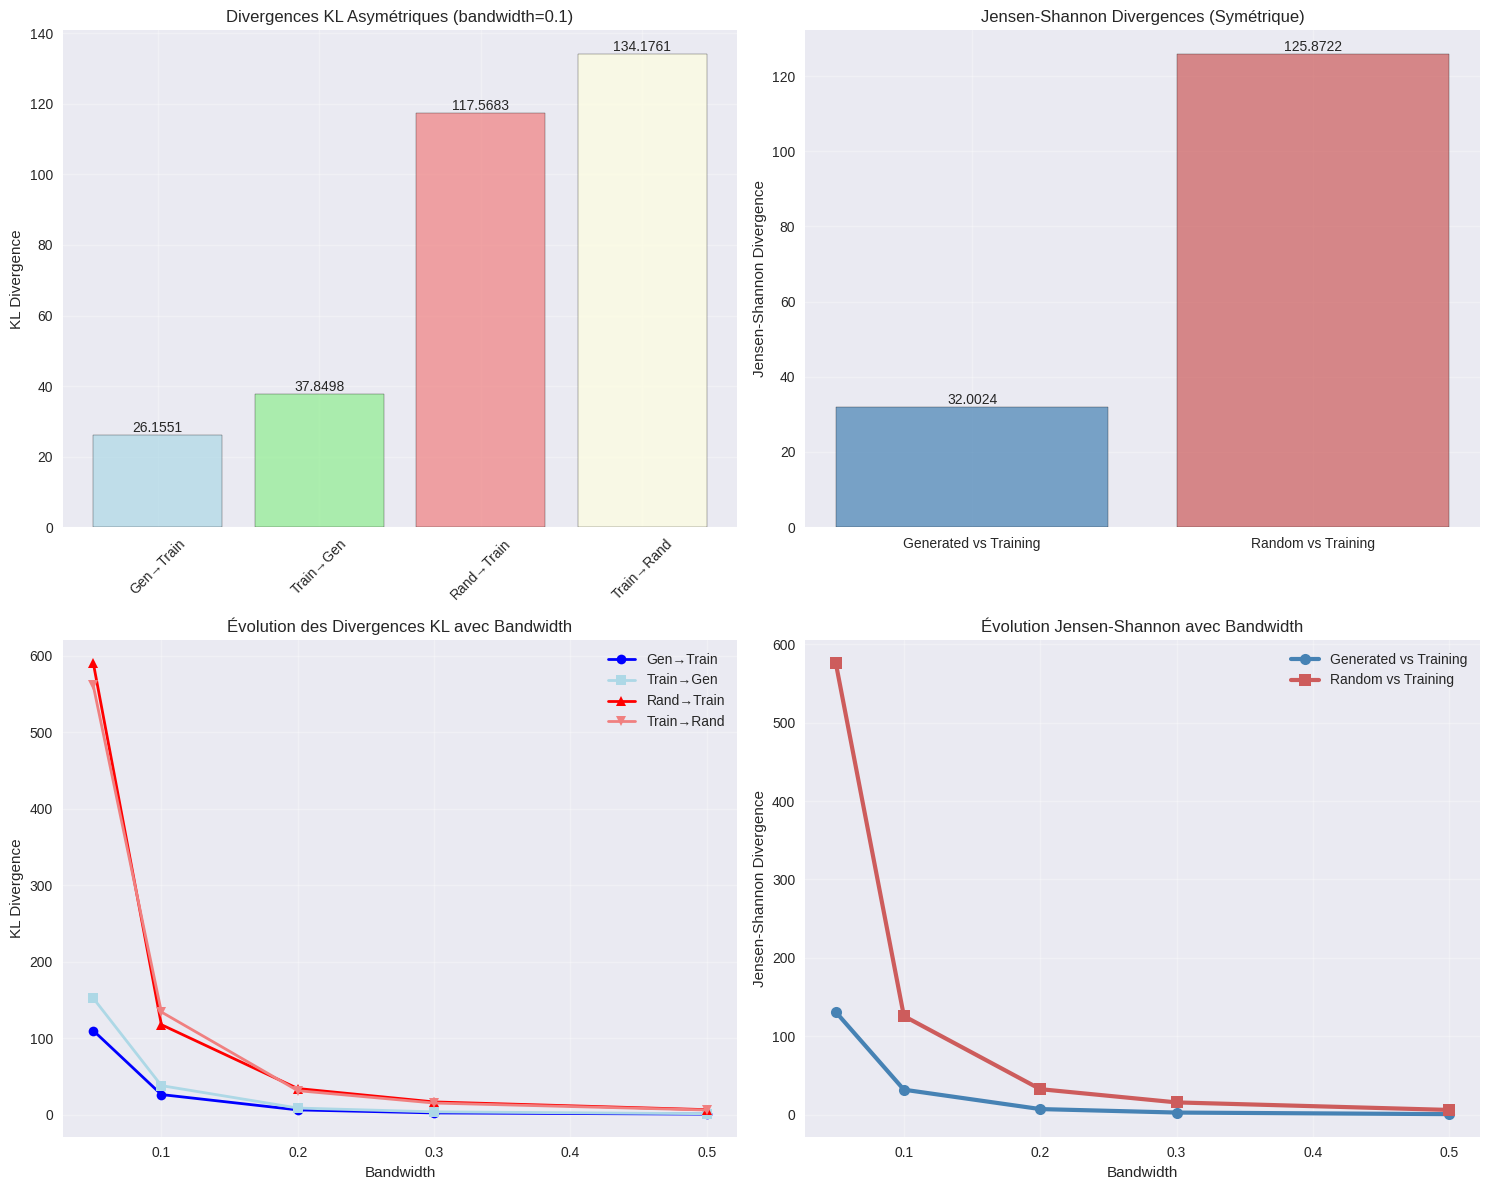


DETAILED KDE KL DIVERGENCE ANALYSIS

1. ASYMMETRIC KL DIVERGENCES (bandwidth=0.1):
   Generated → Training:     26.155096
   Training → Generated:     37.849764
   Random → Training:        117.568341
   Training → Random:        134.176130

2. SYMMETRIC JENSEN-SHANNON DIVERGENCES:
   Generated vs Training:    32.002430
   Random vs Training:       125.872236

3. QUALITY ASSESSMENT:
   JS Improvement over Random: 74.6%
   ✓ Generated sequences are closer to training distribution

4. ASYMMETRY ANALYSIS:
   Generated asymmetry:      11.694669
   Random asymmetry:         16.607789
   ✓ Generated distribution is more symmetric with training

5. BANDWIDTH SENSITIVITY:
   Generated JS std across bandwidths: 49.446057
   Random JS std across bandwidths:    216.765111
   ✓ Generated results are more stable across bandwidths

6. OPTIMAL BANDWIDTH:
   Optimal bandwidth for generated:  0.5
   Minimum JS divergence:            0.814391



In [ ]:

# 3) Test de robustesse avec différents paramètres de bandwidth
print("\nTesting robustness across different bandwidth values...")
bandwidths = [0.05, 0.1, 0.2, 0.3, 0.5]
gen_kl_results = []
rand_kl_results = []

for bw in bandwidths:
    print(f"  Testing bandwidth = {bw}...")
    
    # Pour les séquences générées
    kl_g_t, kl_t_g = calculate_kde_kl_divergence(
        generated_sequences=generated_sequences,
        training_sequences=training_sequences,
        ppl_model=ppl_model,
        ppl_tokenizer=ppl_tokenizer,
        device=device,
        bandwidth=bw,
        n_samples=1000,
        random_seed=42
    )
    
    # Pour les séquences aléatoires
    kl_r_t, kl_t_r = calculate_kde_kl_divergence(
        generated_sequences=random_sequences,
        training_sequences=training_sequences,
        ppl_model=ppl_model,
        ppl_tokenizer=ppl_tokenizer,
        device=device,
        bandwidth=bw,
        n_samples=1000,
        random_seed=42
    )
    
    gen_kl_results.append((kl_g_t, kl_t_g, 0.5 * (kl_g_t + kl_t_g)))
    rand_kl_results.append((kl_r_t, kl_t_r, 0.5 * (kl_r_t + kl_t_r)))

# 4) Visualisations
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# --- Graphique 1: Comparaison des divergences KL asymétriques ---
categories = ['Gen→Train', 'Train→Gen', 'Rand→Train', 'Train→Rand']
values = [kl_gen_train, kl_train_gen, kl_rand_train, kl_train_rand]
colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow']

bars1 = ax1.bar(categories, values, color=colors, alpha=0.7, edgecolor='black')
ax1.set_ylabel('KL Divergence')
ax1.set_title('Divergences KL Asymétriques (bandwidth=0.1)')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3)

# Ajouter les valeurs sur les barres
for bar, val in zip(bars1, values):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{val:.4f}', ha='center', va='bottom', fontsize=10)

# --- Graphique 2: Comparaison Jensen-Shannon ---
js_categories = ['Generated vs Training', 'Random vs Training']
js_values = [js_gen, js_rand]
js_colors = ['steelblue', 'indianred']

bars2 = ax2.bar(js_categories, js_values, color=js_colors, alpha=0.7, edgecolor='black')
ax2.set_ylabel('Jensen-Shannon Divergence')
ax2.set_title('Jensen-Shannon Divergences (Symétrique)')
ax2.grid(True, alpha=0.3)

# Ajouter les valeurs sur les barres
for bar, val in zip(bars2, js_values):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{val:.4f}', ha='center', va='bottom', fontsize=10)

# --- Graphique 3: Évolution avec bandwidth (KL asymétrique) ---
gen_kl_forward = [r[0] for r in gen_kl_results]
gen_kl_backward = [r[1] for r in gen_kl_results]
rand_kl_forward = [r[0] for r in rand_kl_results]
rand_kl_backward = [r[1] for r in rand_kl_results]

ax3.plot(bandwidths, gen_kl_forward, 'o-', label='Gen→Train', color='blue', linewidth=2)
ax3.plot(bandwidths, gen_kl_backward, 's-', label='Train→Gen', color='lightblue', linewidth=2)
ax3.plot(bandwidths, rand_kl_forward, '^-', label='Rand→Train', color='red', linewidth=2)
ax3.plot(bandwidths, rand_kl_backward, 'v-', label='Train→Rand', color='lightcoral', linewidth=2)

ax3.set_xlabel('Bandwidth')
ax3.set_ylabel('KL Divergence')
ax3.set_title('Évolution des Divergences KL avec Bandwidth')
ax3.legend()
ax3.grid(True, alpha=0.3)

# --- Graphique 4: Évolution Jensen-Shannon avec bandwidth ---
gen_js_evolution = [r[2] for r in gen_kl_results]
rand_js_evolution = [r[2] for r in rand_kl_results]

ax4.plot(bandwidths, gen_js_evolution, 'o-', label='Generated vs Training', 
         color='steelblue', linewidth=3, markersize=8)
ax4.plot(bandwidths, rand_js_evolution, 's-', label='Random vs Training', 
         color='indianred', linewidth=3, markersize=8)

ax4.set_xlabel('Bandwidth')
ax4.set_ylabel('Jensen-Shannon Divergence')
ax4.set_title('Évolution Jensen-Shannon avec Bandwidth')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 5) Statistiques et analyse détaillée
print("\n" + "="*60)
print("DETAILED KDE KL DIVERGENCE ANALYSIS")
print("="*60)

print(f"\n1. ASYMMETRIC KL DIVERGENCES (bandwidth=0.1):")
print(f"   Generated → Training:     {kl_gen_train:.6f}")
print(f"   Training → Generated:     {kl_train_gen:.6f}")
print(f"   Random → Training:        {kl_rand_train:.6f}")
print(f"   Training → Random:        {kl_train_rand:.6f}")

print(f"\n2. SYMMETRIC JENSEN-SHANNON DIVERGENCES:")
print(f"   Generated vs Training:    {js_gen:.6f}")
print(f"   Random vs Training:       {js_rand:.6f}")

print(f"\n3. QUALITY ASSESSMENT:")
improvement_js = (js_rand - js_gen) / js_rand * 100
print(f"   JS Improvement over Random: {improvement_js:.1f}%")

if js_gen < js_rand:
    print(f"   ✓ Generated sequences are closer to training distribution")
else:
    print(f"   ✗ Generated sequences are farther from training distribution")

print(f"\n4. ASYMMETRY ANALYSIS:")
gen_asymmetry = abs(kl_gen_train - kl_train_gen)
rand_asymmetry = abs(kl_rand_train - kl_train_rand)
print(f"   Generated asymmetry:      {gen_asymmetry:.6f}")
print(f"   Random asymmetry:         {rand_asymmetry:.6f}")

if gen_asymmetry < rand_asymmetry:
    print(f"   ✓ Generated distribution is more symmetric with training")
else:
    print(f"   ✗ Generated distribution is less symmetric with training")

print(f"\n5. BANDWIDTH SENSITIVITY:")
js_gen_std = np.std(gen_js_evolution)
js_rand_std = np.std(rand_js_evolution)
print(f"   Generated JS std across bandwidths: {js_gen_std:.6f}")
print(f"   Random JS std across bandwidths:    {js_rand_std:.6f}")

if js_gen_std < js_rand_std:
    print(f"   ✓ Generated results are more stable across bandwidths")
else:
    print(f"   ✗ Generated results are less stable across bandwidths")

print(f"\n6. OPTIMAL BANDWIDTH:")
optimal_bw_idx = np.argmin(gen_js_evolution)
optimal_bw = bandwidths[optimal_bw_idx]
optimal_js = gen_js_evolution[optimal_bw_idx]
print(f"   Optimal bandwidth for generated:  {optimal_bw}")
print(f"   Minimum JS divergence:            {optimal_js:.6f}")

print("\n" + "="*60)

### UMAP (DIVERSITY AND FIDELITY)

Extracting embeddings: 100%|██████████| 100/100 [00:00<00:00, 168.26it/s]


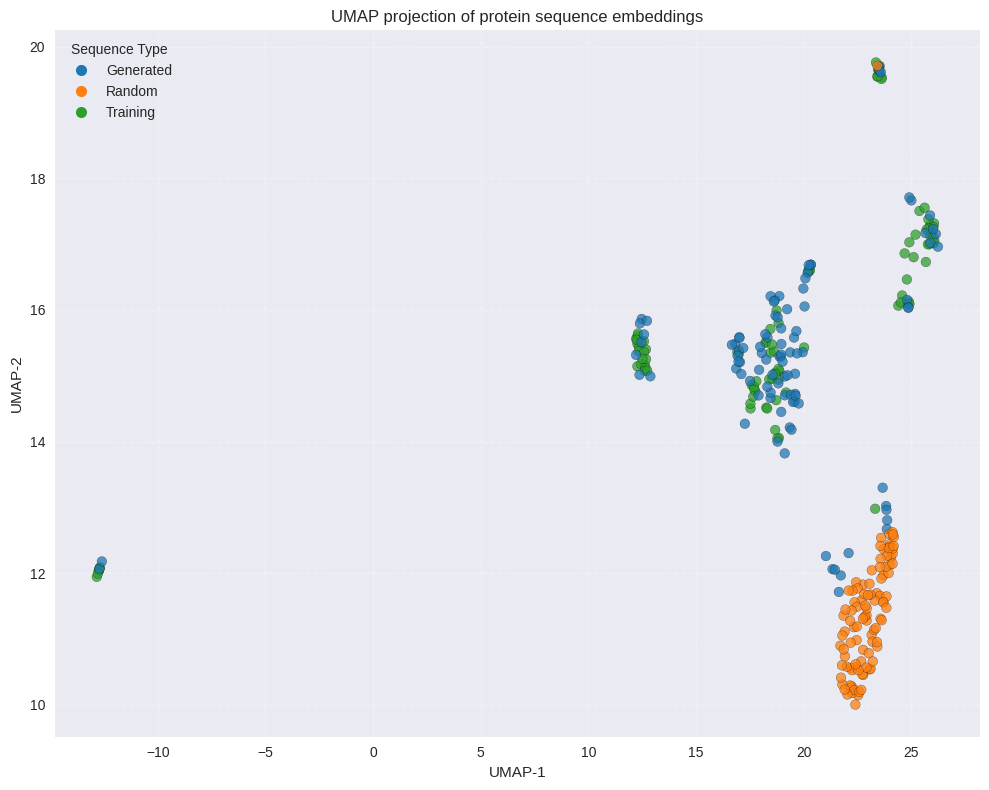

In [ ]:
from umap import UMAP
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
from typing import List, Tuple

def plot_umap(
    embeddings: np.ndarray,
    labels: List[str],
    title: str = "UMAP projection of protein sequence embeddings",
    n_neighbors: int = 30,
    min_dist: float = 0.1,
    metric: str = "cosine",
    figsize: Tuple[int, int] = (10, 8),
    random_state: int = 42
):
    assert len(embeddings) == len(labels)

    scaled_embeddings = StandardScaler().fit_transform(embeddings)
    reducer = UMAP(n_neighbors=n_neighbors, min_dist=min_dist, metric=metric, random_state=random_state)
    umap_result = reducer.fit_transform(scaled_embeddings)

    unique_labels = sorted(set(labels))
    label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}
    colors = [label_to_idx[label] for label in labels]
    cmap = ListedColormap(plt.cm.tab10.colors[:len(unique_labels)])

    plt.figure(figsize=figsize)
    plt.scatter(
        umap_result[:, 0],
        umap_result[:, 1],
        c=colors,
        cmap=cmap,
        alpha=0.75,
        edgecolors='k',
        linewidths=0.2
    )

    handles = [
        plt.Line2D([], [], marker='o', linestyle='', color=cmap(label_to_idx[lab]),
                   label=lab, markersize=8, markeredgecolor='k')
        for lab in unique_labels
    ]
    plt.legend(handles=handles, title="Sequence Type", loc='best')
    plt.title(title)
    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

gen_emb   = get_sequence_embeddings(generated_sequences, ppl_model, ppl_tokenizer, device)
train_emb = get_sequence_embeddings(training_sequences, ppl_model, ppl_tokenizer, device)
rand_emb  = get_sequence_embeddings(random_sequences,    ppl_model, ppl_tokenizer, device)

all_embeddings = np.concatenate([train_emb, gen_emb, rand_emb], axis=0)
all_labels = (
    ["Training"]  * len(train_emb) +
    ["Generated"] * len(gen_emb) +
    ["Random"]    * len(rand_emb)
)

plot_umap(all_embeddings, all_labels)


Extracting embeddings: 100%|██████████| 100/100 [00:00<00:00, 166.69it/s]


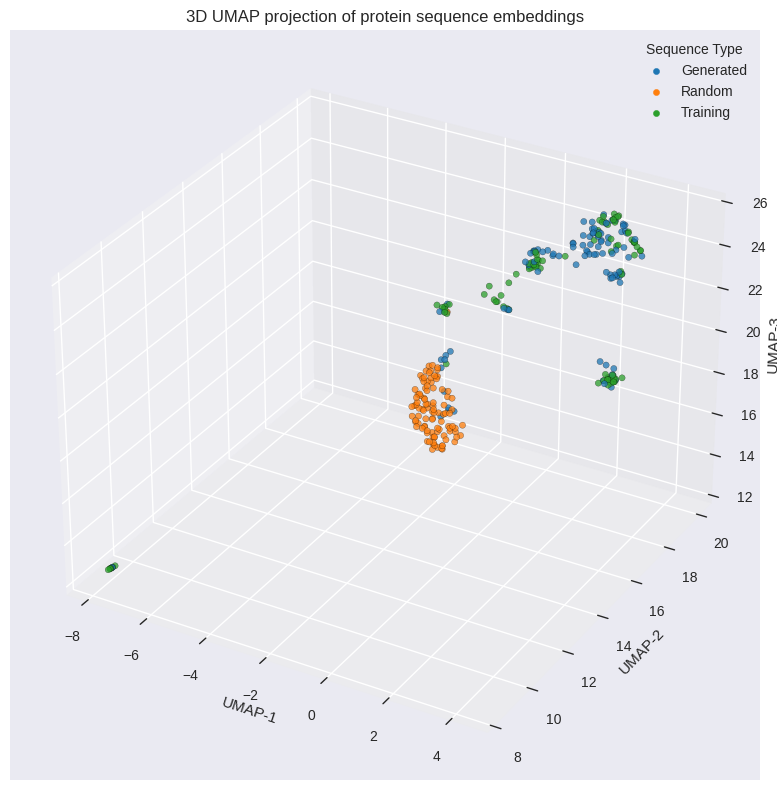

In [ ]:
from umap import UMAP
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (nécessaire pour activer le backend 3D)
import numpy as np
from typing import List, Tuple

def plot_umap_3d(
    embeddings: np.ndarray,
    labels: List[str],
    title: str = "3D UMAP projection of protein sequence embeddings",
    n_neighbors: int = 30,
    min_dist: float = 0.1,
    metric: str = "cosine",
    figsize: Tuple[int, int] = (10, 8),
    random_state: int = 42
):
    assert len(embeddings) == len(labels)

    scaled_embeddings = StandardScaler().fit_transform(embeddings)
    reducer = UMAP(n_components=3, n_neighbors=n_neighbors, min_dist=min_dist, metric=metric, random_state=random_state)
    umap_result = reducer.fit_transform(scaled_embeddings)

    unique_labels = sorted(set(labels))
    label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}
    colors = [label_to_idx[label] for label in labels]
    cmap = ListedColormap(plt.cm.tab10.colors[:len(unique_labels)])

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(
        umap_result[:, 0],
        umap_result[:, 1],
        umap_result[:, 2],
        c=colors,
        cmap=cmap,
        alpha=0.75,
        edgecolors='k',
        linewidths=0.2
    )

    for lab in unique_labels:
        ax.scatter([], [], [], color=cmap(label_to_idx[lab]), label=lab)
    ax.legend(title="Sequence Type", loc='best')

    ax.set_title(title)
    ax.set_xlabel("UMAP-1")
    ax.set_ylabel("UMAP-2")
    ax.set_zlabel("UMAP-3")
    plt.tight_layout()
    plt.show()

gen_emb   = get_sequence_embeddings(generated_sequences, ppl_model, ppl_tokenizer, device)
train_emb = get_sequence_embeddings(training_sequences, ppl_model, ppl_tokenizer, device)
rand_emb  = get_sequence_embeddings(random_sequences,    ppl_model, ppl_tokenizer, device)

all_embeddings = np.concatenate([train_emb, gen_emb, rand_emb], axis=0)
all_labels = (
    ["Training"]  * len(train_emb) +
    ["Generated"] * len(gen_emb) +
    ["Random"]    * len(rand_emb)
)

plot_umap_3d(all_embeddings, all_labels)


### EIGEN VALUES (DIVERSITY AND FIDELITY)

In [ ]:
# Analyse des Eigenvalues - Comparaison des Distributions d'Embeddings
print("Calculating Eigenvalues for all sequence sets...")

# Calcul des eigenvalues pour chaque ensemble
print("1. Training sequences...")
eigenvals_training = get_embeddings_eigenvalues(
    sequences=training_sequences,
    ppl_model=ppl_model,
    ppl_tokenizer=ppl_tokenizer,
    device=device
)

print("2. Generated sequences...")
eigenvals_generated = get_embeddings_eigenvalues(
    sequences=generated_sequences,
    ppl_model=ppl_model,
    ppl_tokenizer=ppl_tokenizer,
    device=device
)

print("3. Random sequences...")
eigenvals_random = get_embeddings_eigenvalues(
    sequences=random_sequences,
    ppl_model=ppl_model,
    ppl_tokenizer=ppl_tokenizer,
    device=device
)

print(f"Eigenvalues computed:")
print(f"  Training: {len(eigenvals_training)} eigenvalues")
print(f"  Generated: {len(eigenvals_generated)} eigenvalues")
print(f"  Random: {len(eigenvals_random)} eigenvalues")

Calculating Eigenvalues for all sequence sets...
1. Training sequences...
2. Generated sequences...
3. Random sequences...
Eigenvalues computed:
  Training: 320 eigenvalues
  Generated: 320 eigenvalues
  Random: 320 eigenvalues


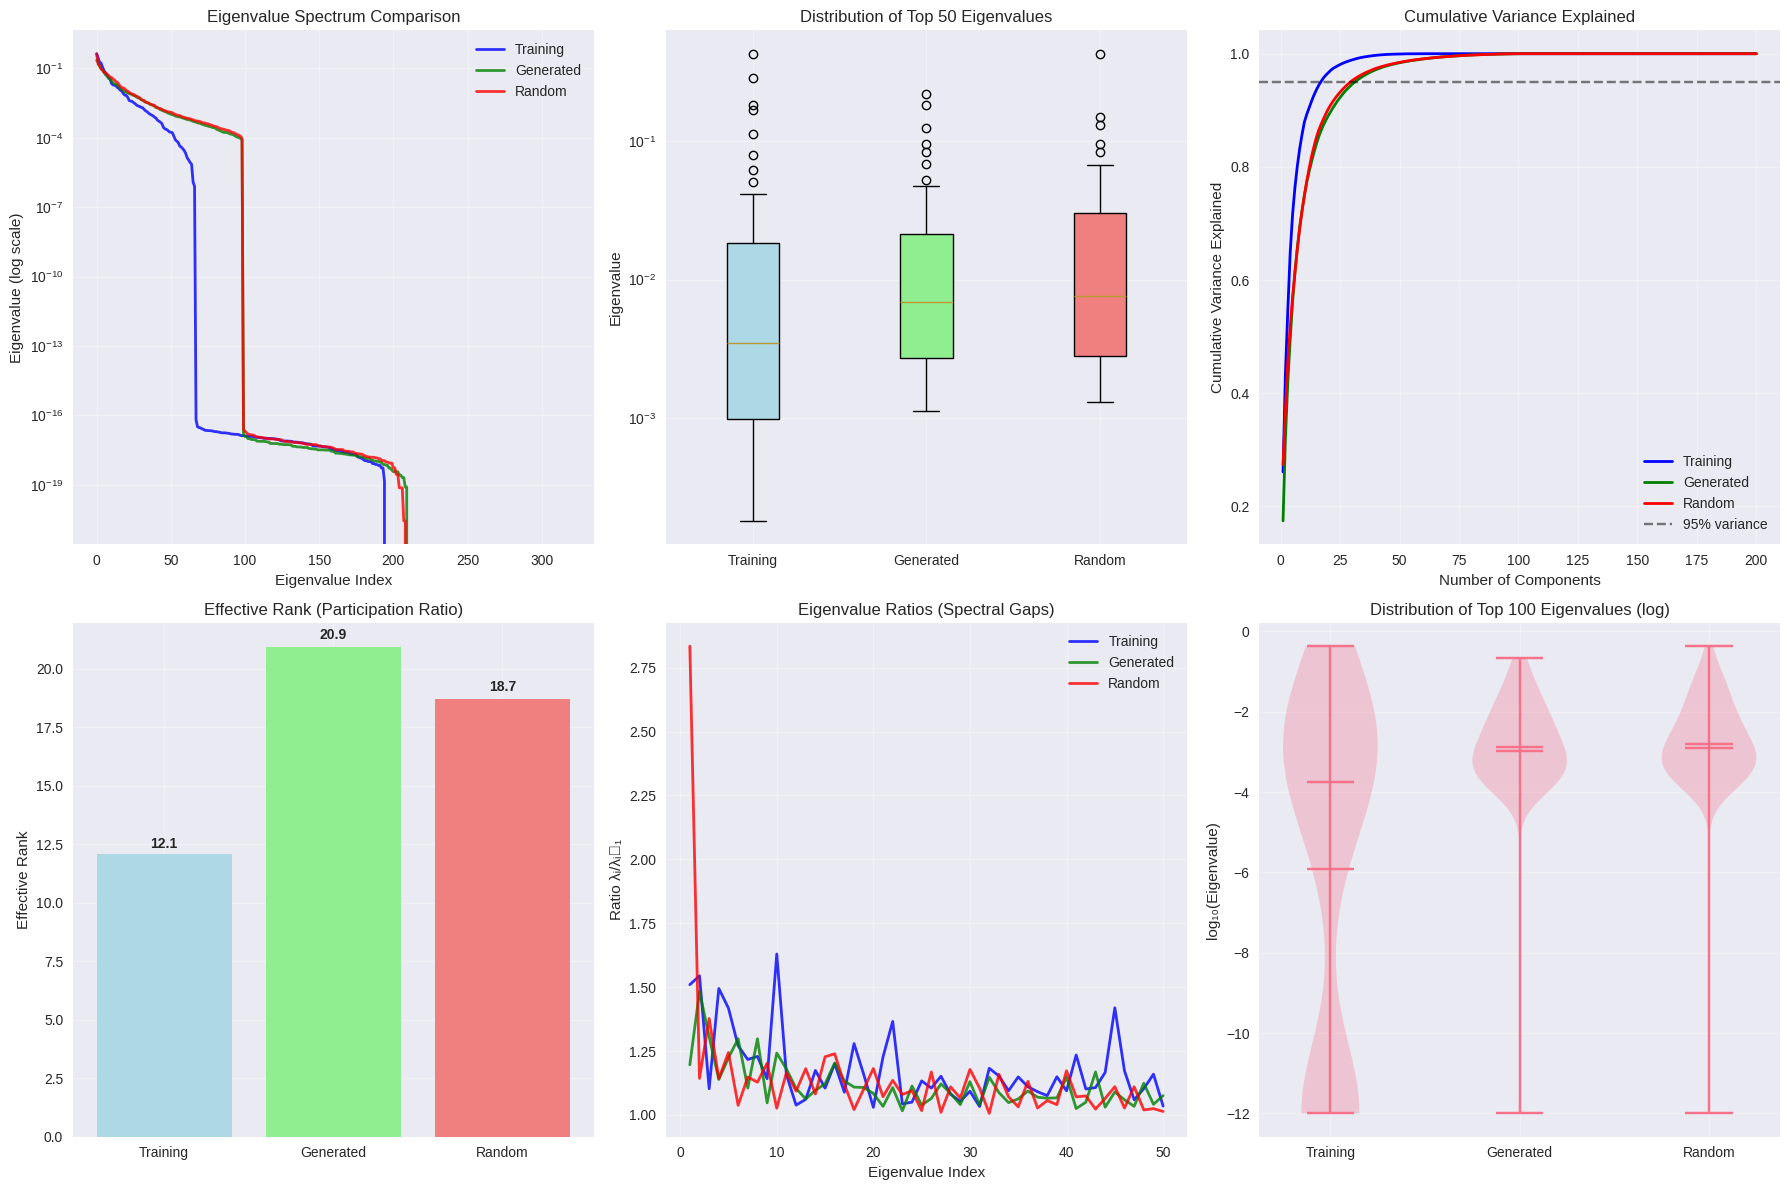

In [ ]:

# Visualizations complètes
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Spectrum des eigenvalues (log scale)
ax1 = axes[0, 0]
indices_train = np.arange(len(eigenvals_training))
indices_gen = np.arange(len(eigenvals_generated))
indices_rand = np.arange(len(eigenvals_random))

ax1.semilogy(indices_train, eigenvals_training, 'b-', label='Training', alpha=0.8, linewidth=2)
ax1.semilogy(indices_gen, eigenvals_generated, 'g-', label='Generated', alpha=0.8, linewidth=2)
ax1.semilogy(indices_rand, eigenvals_random, 'r-', label='Random', alpha=0.8, linewidth=2)
ax1.set_xlabel('Eigenvalue Index')
ax1.set_ylabel('Eigenvalue (log scale)')
ax1.set_title('Eigenvalue Spectrum Comparison')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Distribution des top eigenvalues
ax2 = axes[0, 1]
n_top = min(50, len(eigenvals_training), len(eigenvals_generated), len(eigenvals_random))
data_top = [eigenvals_training[:n_top], eigenvals_generated[:n_top], eigenvals_random[:n_top]]
bp = ax2.boxplot(data_top, labels=['Training', 'Generated', 'Random'], patch_artist=True)
colors = ['lightblue', 'lightgreen', 'lightcoral']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
ax2.set_ylabel('Eigenvalue')
ax2.set_title(f'Distribution of Top {n_top} Eigenvalues')
ax2.set_yscale('log')
ax2.grid(True, alpha=0.3)

# 3. Variance expliquée cumulative
ax3 = axes[0, 2]
def cumulative_variance_explained(eigenvals):
    total_var = np.sum(eigenvals)
    cum_var = np.cumsum(eigenvals) / total_var
    return cum_var

cum_var_train = cumulative_variance_explained(eigenvals_training)
cum_var_gen = cumulative_variance_explained(eigenvals_generated)
cum_var_rand = cumulative_variance_explained(eigenvals_random)

n_components = min(200, len(cum_var_train), len(cum_var_gen), len(cum_var_rand))
ax3.plot(range(1, n_components+1), cum_var_train[:n_components], 'b-', label='Training', linewidth=2)
ax3.plot(range(1, n_components+1), cum_var_gen[:n_components], 'g-', label='Generated', linewidth=2)
ax3.plot(range(1, n_components+1), cum_var_rand[:n_components], 'r-', label='Random', linewidth=2)
ax3.axhline(y=0.95, color='k', linestyle='--', alpha=0.5, label='95% variance')
ax3.set_xlabel('Number of Components')
ax3.set_ylabel('Cumulative Variance Explained')
ax3.set_title('Cumulative Variance Explained')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Effective rank (participation ratio)
ax4 = axes[1, 0]
def effective_rank(eigenvals):
    eigenvals_norm = eigenvals / np.sum(eigenvals)
    return np.exp(-np.sum(eigenvals_norm * np.log(eigenvals_norm + 1e-12)))

eff_rank_train = effective_rank(eigenvals_training)
eff_rank_gen = effective_rank(eigenvals_generated)
eff_rank_rand = effective_rank(eigenvals_random)

ranks = [eff_rank_train, eff_rank_gen, eff_rank_rand]
labels = ['Training', 'Generated', 'Random']
bars = ax4.bar(labels, ranks, color=['lightblue', 'lightgreen', 'lightcoral'])
ax4.set_ylabel('Effective Rank')
ax4.set_title('Effective Rank (Participation Ratio)')
ax4.grid(True, alpha=0.3)

# Ajouter les valeurs sur les barres
for bar, rank in zip(bars, ranks):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'{rank:.1f}', ha='center', va='bottom', fontweight='bold')

# 5. Ratio des eigenvalues principales
ax5 = axes[1, 1]
ratios_train = eigenvals_training[:-1] / eigenvals_training[1:]
ratios_gen = eigenvals_generated[:-1] / eigenvals_generated[1:]
ratios_rand = eigenvals_random[:-1] / eigenvals_random[1:]

n_ratios = min(50, len(ratios_train), len(ratios_gen), len(ratios_rand))
ax5.plot(range(1, n_ratios+1), ratios_train[:n_ratios], 'b-', label='Training', alpha=0.8, linewidth=2)
ax5.plot(range(1, n_ratios+1), ratios_gen[:n_ratios], 'g-', label='Generated', alpha=0.8, linewidth=2)
ax5.plot(range(1, n_ratios+1), ratios_rand[:n_ratios], 'r-', label='Random', alpha=0.8, linewidth=2)
ax5.set_xlabel('Eigenvalue Index')
ax5.set_ylabel('Ratio λᵢ/λᵢ₊₁')
ax5.set_title('Eigenvalue Ratios (Spectral Gaps)')
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6. Violin plot des distributions
ax6 = axes[1, 2]
n_violin = min(100, len(eigenvals_training), len(eigenvals_generated), len(eigenvals_random))
data_violin = [
    np.log10(eigenvals_training[:n_violin] + 1e-12),
    np.log10(eigenvals_generated[:n_violin] + 1e-12),
    np.log10(eigenvals_random[:n_violin] + 1e-12)
]
parts = ax6.violinplot(data_violin, positions=[1, 2, 3], showmeans=True, showmedians=True)
ax6.set_xticks([1, 2, 3])
ax6.set_xticklabels(['Training', 'Generated', 'Random'])
ax6.set_ylabel('log₁₀(Eigenvalue)')
ax6.set_title(f'Distribution of Top {n_violin} Eigenvalues (log)')
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:

# Analyse statistique détaillée
print("\n" + "="*70)
print("EIGENVALUE ANALYSIS SUMMARY")
print("="*70)

datasets = [
    ('Training', eigenvals_training),
    ('Generated', eigenvals_generated),
    ('Random', eigenvals_random)
]

for name, eigenvals in datasets:
    print(f"\n{name} sequences:")
    print(f"  Number of eigenvalues: {len(eigenvals)}")
    print(f"  Sum of eigenvalues (total variance): {np.sum(eigenvals):.3f}")
    print(f"  Largest eigenvalue: {eigenvals[0]:.3f}")
    print(f"  Smallest eigenvalue: {eigenvals[-1]:.6f}")
    
    # Effective rank
    eff_rank = effective_rank(eigenvals)
    print(f"  Effective rank: {eff_rank:.1f}")
    
    # Variance explained by top components
    cum_var = cumulative_variance_explained(eigenvals)
    for pct in [50, 90, 95, 99]:
        n_comp = np.argmax(cum_var >= pct/100) + 1
        print(f"  Components for {pct}% variance: {n_comp}")
    
    # Spectral properties
    if len(eigenvals) > 1:
        condition_number = eigenvals[0] / eigenvals[-1]
        print(f"  Condition number: {condition_number:.2e}")
    
    # Entropy of eigenvalue distribution
    eigenvals_norm = eigenvals / np.sum(eigenvals)
    entropy = -np.sum(eigenvals_norm * np.log(eigenvals_norm + 1e-12))
    print(f"  Spectral entropy: {entropy:.3f}")

# Comparaisons relatives
print(f"\n" + "="*70)
print("RELATIVE COMPARISONS")
print("="*70)

# Compare effective ranks
print(f"\nEffective Rank Ratios:")
print(f"  Generated/Training: {eff_rank_gen/eff_rank_train:.3f}")
print(f"  Random/Training: {eff_rank_rand/eff_rank_train:.3f}")
print(f"  Generated/Random: {eff_rank_gen/eff_rank_rand:.3f}")

# Compare top eigenvalues
print(f"\nTop Eigenvalue Ratios:")
print(f"  Generated/Training: {eigenvals_generated[0]/eigenvals_training[0]:.3f}")
print(f"  Random/Training: {eigenvals_random[0]/eigenvals_training[0]:.3f}")
print(f"  Generated/Random: {eigenvals_generated[0]/eigenvals_random[0]:.3f}")


EIGENVALUE ANALYSIS SUMMARY

Training sequences:
  Number of eigenvalues: 320
  Sum of eigenvalues (total variance): 1.647
  Largest eigenvalue: 0.430
  Smallest eigenvalue: -0.000000
  Effective rank: 12.1
  Components for 50% variance: 3
  Components for 90% variance: 12
  Components for 95% variance: 17
  Components for 99% variance: 31
  Condition number: -7.63e+15
  Spectral entropy: 2.494

Generated sequences:
  Number of eigenvalues: 320
  Sum of eigenvalues (total variance): 1.258
  Largest eigenvalue: 0.220
  Smallest eigenvalue: -0.000000
  Effective rank: 20.9
  Components for 50% variance: 5
  Components for 90% variance: 22
  Components for 95% variance: 32
  Components for 99% variance: 59
  Condition number: -1.43e+16
  Spectral entropy: 3.041

Random sequences:
  Number of eigenvalues: 320
  Sum of eigenvalues (total variance): 1.554
  Largest eigenvalue: 0.425
  Smallest eigenvalue: -0.000000
  Effective rank: 18.7
  Components for 50% variance: 4
  Components for 90%

In [ ]:

# Interpretation
print(f"\n" + "="*70)
print("INTERPRETATION")
print("="*70)

print(f"""
Eigenvalue analysis reveals the intrinsic dimensionality and structure of sequence embeddings:

1. EFFECTIVE RANK: Measures the 'true' dimensionality of the embedding space
   - Higher rank → more diverse, complex representations
   - Lower rank → more constrained, structured representations

2. SPECTRAL DISTRIBUTION: Shape of eigenvalue decay
   - Rapid decay → low intrinsic dimensionality
   - Slow decay → high intrinsic dimensionality

3. CONDITION NUMBER: Ratio of largest to smallest eigenvalue
   - High condition number → ill-conditioned, numerical instability
   - Low condition number → well-conditioned representations

4. VARIANCE CONCENTRATION: How much variance is captured by top components
   - High concentration → representations lie in low-dimensional subspace
   - Low concentration → representations use full dimensional space

Key Findings:
- Generated sequences effective rank: {eff_rank_gen:.1f}
- Training sequences effective rank: {eff_rank_train:.1f}
- Random sequences effective rank: {eff_rank_rand:.1f}

The eigenvalue spectrum comparison reveals whether generated sequences maintain
the same representational complexity as training data or become more constrained.
""")


INTERPRETATION

Eigenvalue analysis reveals the intrinsic dimensionality and structure of sequence embeddings:

1. EFFECTIVE RANK: Measures the 'true' dimensionality of the embedding space
   - Higher rank → more diverse, complex representations
   - Lower rank → more constrained, structured representations

2. SPECTRAL DISTRIBUTION: Shape of eigenvalue decay
   - Rapid decay → low intrinsic dimensionality
   - Slow decay → high intrinsic dimensionality

3. CONDITION NUMBER: Ratio of largest to smallest eigenvalue
   - High condition number → ill-conditioned, numerical instability
   - Low condition number → well-conditioned representations

4. VARIANCE CONCENTRATION: How much variance is captured by top components
   - High concentration → representations lie in low-dimensional subspace
   - Low concentration → representations use full dimensional space

Key Findings:
- Generated sequences effective rank: 20.9
- Training sequences effective rank: 12.1
- Random sequences effective ran

### TOP P&R (DIVERSITY AND FIDELITY)

In [ ]:
# Calculate TopP&R Metrics
print("Calculating TopP&R Metrics...")

# 1) Calcul des métriques TopP&R pour les séquences générées
toppr_gen_fidelity, toppr_gen_diversity, toppr_gen_f1 = calculate_toppr_score(
    generated_sequences=generated_sequences,
    training_sequences=training_sequences,
    ppl_model=ppl_model,
    ppl_tokenizer=ppl_tokenizer,
    device=device,
    alpha=0.1,
    kernel="cosine",
    random_proj=True
)

# 2) Calcul des métriques TopP&R pour les séquences aléatoires (baseline)
toppr_rand_fidelity, toppr_rand_diversity, toppr_rand_f1 = calculate_toppr_score(
    generated_sequences=random_sequences,
    training_sequences=training_sequences,
    ppl_model=ppl_model,
    ppl_tokenizer=ppl_tokenizer,
    device=device,
    alpha=0.1,
    kernel="cosine",
    random_proj=True
)

print(f"Generated - Fidelity (TopP): {toppr_gen_fidelity:.3f}")
print(f"Generated - Diversity (TopR): {toppr_gen_diversity:.3f}")
print(f"Generated - F1-Score: {toppr_gen_f1:.3f}")
print(f"Random - Fidelity (TopP): {toppr_rand_fidelity:.3f}")
print(f"Random - Diversity (TopR): {toppr_rand_diversity:.3f}")
print(f"Random - F1-Score: {toppr_rand_f1:.3f}")

Calculating TopP&R Metrics...
Extracting embeddings for TopP&R calculation...


Extracting embeddings: 100%|██████████| 1000/1000 [00:06<00:00, 164.55it/s]


Computing TopP&R...
Extracting embeddings for TopP&R calculation...


Extracting embeddings: 100%|██████████| 1000/1000 [00:06<00:00, 166.26it/s]


Computing TopP&R...
Generated - Fidelity (TopP): 0.777
Generated - Diversity (TopR): 0.932
Generated - F1-Score: 0.847
Random - Fidelity (TopP): 0.113
Random - Diversity (TopR): 0.053
Random - F1-Score: 0.072


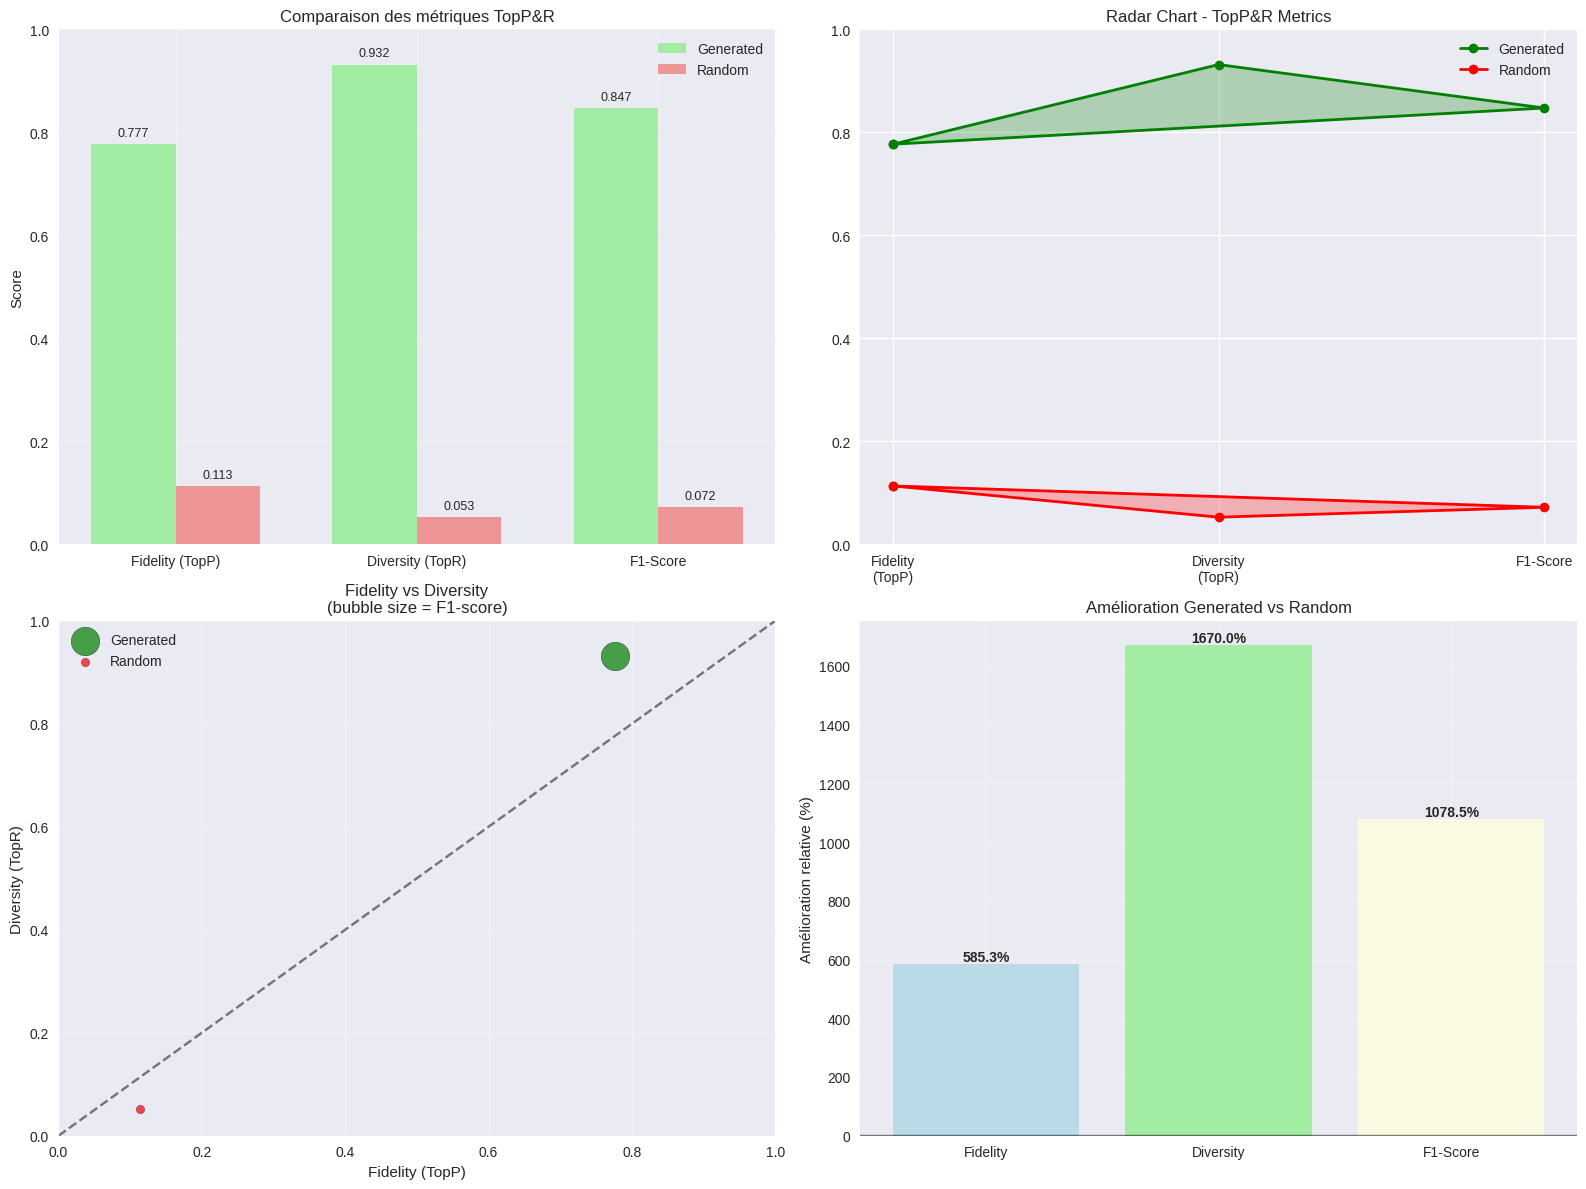


TopP&R Analysis:

Generated Sequences:
  Fidelity (TopP):     0.777
  Diversity (TopR):    0.932
  F1-Score:            0.847
  Balance Score:       0.847

Random Sequences (Baseline):
  Fidelity (TopP):     0.113
  Diversity (TopR):    0.053
  F1-Score:            0.072
  Balance Score:       0.072

Relative Improvements:
  Fidelity improvement:   +585.3%
  Diversity improvement:  +1670.0%
  F1-Score improvement:   +1078.5%

Qualitative Assessment:
Fidelity Assessment:  Excellent (0.777)
Diversity Assessment: Excellent (0.932)
Balance Assessment:   Well-balanced (ratio: 0.834)
Overall Assessment:   Excellent generation quality


In [ ]:

# 3) Visualisations des métriques TopP&R
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# --- Barplot comparatif des métriques ---
metrics = ['Fidelity (TopP)', 'Diversity (TopR)', 'F1-Score']
gen_values = [toppr_gen_fidelity, toppr_gen_diversity, toppr_gen_f1]
rand_values = [toppr_rand_fidelity, toppr_rand_diversity, toppr_rand_f1]

x = np.arange(len(metrics))
width = 0.35

bars1 = ax1.bar(x - width/2, gen_values, width, label='Generated', color='lightgreen', alpha=0.8)
bars2 = ax1.bar(x + width/2, rand_values, width, label='Random', color='lightcoral', alpha=0.8)

ax1.set_ylabel('Score')
ax1.set_title('Comparaison des métriques TopP&R')
ax1.set_xticks(x)
ax1.set_xticklabels(metrics)
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 1)

# Ajout des valeurs sur les barres
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01, f'{height:.3f}', 
             ha='center', va='bottom', fontsize=9)
for bar in bars2:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01, f'{height:.3f}', 
             ha='center', va='bottom', fontsize=9)

# --- Radar chart pour visualiser le balance Fidelity/Diversity ---
categories = ['Fidelity\n(TopP)', 'Diversity\n(TopR)', 'F1-Score']
N = len(categories)

# Angles pour le radar chart
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]  # Fermer le cercle

# Données pour le radar
gen_radar = gen_values + [gen_values[0]]
rand_radar = rand_values + [rand_values[0]]

ax2.plot(angles, gen_radar, 'o-', linewidth=2, label='Generated', color='green')
ax2.fill(angles, gen_radar, alpha=0.25, color='green')
ax2.plot(angles, rand_radar, 'o-', linewidth=2, label='Random', color='red')
ax2.fill(angles, rand_radar, alpha=0.25, color='red')

ax2.set_xticks(angles[:-1])
ax2.set_xticklabels(categories)
ax2.set_ylim(0, 1)
ax2.set_title('Radar Chart - TopP&R Metrics')
ax2.legend()
ax2.grid(True)

# --- Graphique de performance globale (F1 vs Fidelity vs Diversity) ---
# Scatter plot avec taille proportionnelle au F1-score
scatter_gen = ax3.scatter(toppr_gen_fidelity, toppr_gen_diversity, 
                         s=toppr_gen_f1*500, alpha=0.7, color='green', 
                         label='Generated', edgecolors='black')
scatter_rand = ax3.scatter(toppr_rand_fidelity, toppr_rand_diversity, 
                          s=toppr_rand_f1*500, alpha=0.7, color='red', 
                          label='Random', edgecolors='black')

ax3.set_xlabel('Fidelity (TopP)')
ax3.set_ylabel('Diversity (TopR)')
ax3.set_title('Fidelity vs Diversity\n(bubble size = F1-score)')
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.set_xlim(0, 1)
ax3.set_ylim(0, 1)

# Ligne diagonale pour référence (balance idéal)
ax3.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Perfect Balance')

# --- Histogramme des améliorations relatives ---
improvements = {
    'Fidelity': (toppr_gen_fidelity - toppr_rand_fidelity) / toppr_rand_fidelity * 100,
    'Diversity': (toppr_gen_diversity - toppr_rand_diversity) / toppr_rand_diversity * 100,
    'F1-Score': (toppr_gen_f1 - toppr_rand_f1) / toppr_rand_f1 * 100
}

colors = ['lightblue', 'lightgreen', 'lightyellow']
bars = ax4.bar(improvements.keys(), improvements.values(), color=colors, alpha=0.8)
ax4.set_ylabel('Amélioration relative (%)')
ax4.set_title('Amélioration Generated vs Random')
ax4.grid(True, alpha=0.3)
ax4.axhline(y=0, color='black', linestyle='-', alpha=0.5)

# Ajout des valeurs sur les barres
for bar, value in zip(bars, improvements.values()):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + (1 if height > 0 else -3), 
             f'{value:.1f}%', ha='center', va='bottom' if height > 0 else 'top', 
             fontweight='bold')

plt.tight_layout()
plt.show()

# 4) Statistiques descriptives et analyse
print("\nTopP&R Analysis:")
print("================")

print(f"\nGenerated Sequences:")
print(f"  Fidelity (TopP):     {toppr_gen_fidelity:.3f}")
print(f"  Diversity (TopR):    {toppr_gen_diversity:.3f}")
print(f"  F1-Score:            {toppr_gen_f1:.3f}")
print(f"  Balance Score:       {2 * toppr_gen_fidelity * toppr_gen_diversity / (toppr_gen_fidelity + toppr_gen_diversity):.3f}")

print(f"\nRandom Sequences (Baseline):")
print(f"  Fidelity (TopP):     {toppr_rand_fidelity:.3f}")
print(f"  Diversity (TopR):    {toppr_rand_diversity:.3f}")
print(f"  F1-Score:            {toppr_rand_f1:.3f}")
print(f"  Balance Score:       {2 * toppr_rand_fidelity * toppr_rand_diversity / (toppr_rand_fidelity + toppr_rand_diversity):.3f}")

print(f"\nRelative Improvements:")
print(f"  Fidelity improvement:   {improvements['Fidelity']:+.1f}%")
print(f"  Diversity improvement:  {improvements['Diversity']:+.1f}%")
print(f"  F1-Score improvement:   {improvements['F1-Score']:+.1f}%")

# 5) Interprétation qualitative
print(f"\nQualitative Assessment:")
print("=" * 25)

if toppr_gen_fidelity > 0.7:
    fidelity_assessment = "Excellent"
elif toppr_gen_fidelity > 0.5:
    fidelity_assessment = "Good"
elif toppr_gen_fidelity > 0.3:
    fidelity_assessment = "Moderate"
else:
    fidelity_assessment = "Poor"

if toppr_gen_diversity > 0.7:
    diversity_assessment = "Excellent"
elif toppr_gen_diversity > 0.5:
    diversity_assessment = "Good"
elif toppr_gen_diversity > 0.3:
    diversity_assessment = "Moderate"
else:
    diversity_assessment = "Poor"

print(f"Fidelity Assessment:  {fidelity_assessment} ({toppr_gen_fidelity:.3f})")
print(f"Diversity Assessment: {diversity_assessment} ({toppr_gen_diversity:.3f})")

# Balance analysis
balance_ratio = min(toppr_gen_fidelity, toppr_gen_diversity) / max(toppr_gen_fidelity, toppr_gen_diversity)
if balance_ratio > 0.8:
    balance_assessment = "Well-balanced"
elif balance_ratio > 0.6:
    balance_assessment = "Moderately balanced"
else:
    balance_assessment = "Imbalanced"

print(f"Balance Assessment:   {balance_assessment} (ratio: {balance_ratio:.3f})")

# Overall recommendation
if toppr_gen_f1 > 0.7:
    overall = "Excellent generation quality"
elif toppr_gen_f1 > 0.5:
    overall = "Good generation quality"
elif toppr_gen_f1 > 0.3:
    overall = "Moderate generation quality"
else:
    overall = "Poor generation quality - consider model improvements"

print(f"Overall Assessment:   {overall}")